In [1]:
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    label_binarize)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    log_loss,
    average_precision_score,
    roc_curve,
    precision_recall_curve)
from sklearn.calibration import calibration_curve


In [4]:
# loading the data
df = pd.read_csv("loan.csv")
df.shape
df_raw = df.copy()

/var/folders/wn/wpy04pb15y934q92j5gbcvb80000gn/T/ipykernel_48946/3977509200.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [5]:
# -------------------------------------------------------------
# Step 1: Create the 3-class target (common for both pipelines)
# -------------------------------------------------------------
def create_target(df):
    """
    Creates the 3-class target:
      - paid_on_time
      - paid_late
      - not_paid

    Also computes helper columns needed to classify paid_late correctly.
    """
    df = df.copy()

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')

    # Extract loan term in months
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Approximate expected end date
    df['expected_end'] = df['issue_d'] + pd.to_timedelta(df['term_months'] * 30, unit='D')

    # Late fully paid flag
    df['paid_late_flag'] = (
        (df['loan_status'] == 'Fully Paid') &
        (df['last_pymnt_d'] > df['expected_end'])
    )

    # Build target variable
    df['target_3class'] = 'paid_on_time'
    df.loc[df['paid_late_flag'], 'target_3class'] = 'paid_late'
    df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'target_3class'] = 'not_paid'
    # Remove '(future leakage + breaks categorical encoding)
    df = df.drop(columns=['next_pymnt_d', 'paid_late_flag', 'last_pymnt_d', 'expected_end'], errors='ignore')

    return df[df['target_3class'].notna()].reset_index(drop=True)

In [6]:
# אחרי שקראת לפונקציה:
df_with_target = create_target(df)

# ספירה בכל מחלקה
counts = df_with_target["target_3class"].value_counts(dropna=False)
print("Counts per class:\n", counts)

# אחוזים בכל מחלקה
pct = df_with_target["target_3class"].value_counts(normalize=True) * 100
print("\nPercent per class:\n", pct.round(2))

# סה"כ
print("\nTotal rows:", len(df_with_target))


Counts per class:
 target_3class
paid_on_time    1788541
not_paid         261686
paid_late        210441
Name: count, dtype: int64

Percent per class:
 target_3class
paid_on_time    79.12
not_paid        11.58
paid_late        9.31
Name: proportion, dtype: float64

Total rows: 2260668


In [13]:
# =============================================================
# FULL CLEAN PIPELINE (30 variables clean)
# =============================================================
leakage_columns = [
    'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
    'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
    'out_prncp_inv','loan_status'
]

high_corr_drop_columns = [
    'funded_amnt','funded_amnt_inv','installment',
    'num_rev_tl_bal_gt_0','tot_hi_cred_lim',
    'total_il_high_credit_limit','num_sats'
]

redundant_columns = ['policy_code','disbursement_method','chargeoff_within_12_mths', 'initial_list_status']


def basic_clean1(df):
    """
    First stage of full clean:
    - Remove leakage, high correlation, and redundant columns
    - Drop columns with >90% missing
    - Clean term and emp_length
    - Remove rows with missing target
    """
    clean_df = df.copy()

    cols_to_drop = [c for c in (leakage_columns + high_corr_drop_columns + redundant_columns) 
                    if c in clean_df.columns]
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Drop columns with excessive missingness
    missing_pct = clean_df.isnull().mean() * 100
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing_cols)

    # Remove "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified']
    clean_df = clean_df.drop(columns=['verification_status'], errors='ignore')

    # Clean term (36/60)
    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Clean employee length
    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    return clean_df[clean_df['target_3class'].notna()].reset_index(drop=True)


def basic_clean2(df):
    """
    Second stage of full clean:
    - Remove non-informative columns
    - Normalize text columns
    - Create engineered features (purpose_grouped, home_stability, credit_age_years, etc.)
    - Remove raw columns after feature engineering
    """
    clean_df = df.copy()

    # Non-informative
    for col in ['pymnt_plan','zip_code','collections_12_mths_ex_med']:
        clean_df = clean_df.drop(columns=col, errors='ignore')

    # Lowercase text columns
    for col in ['purpose','home_ownership','addr_state','application_type','emp_title']:
        if col in clean_df:
            clean_df[col] = clean_df[col].astype(str).str.lower().str.strip()

    # Grouped purpose variable
    clean_df['purpose_grouped'] = clean_df['purpose'].replace({
        'debt_consolidation':'debt','credit_card':'debt',
        'home_improvement':'housing','house':'housing',
        'small_business':'business',
        'car':'personal','medical':'personal','vacation':'personal','moving':'personal',
        'wedding':'personal','major_purchase':'personal',
        'renewable_energy':'other','educational':'other','other':'other'
    })

    # Home stability
    clean_df['home_stability'] = clean_df['home_ownership'].replace({
        'mortgage':'stable','own':'stable',
        'rent':'unstable','none':'unstable','other':'unstable'
    })

    # Credit age
    years = clean_df['earliest_cr_line'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    clean_df['credit_age_years'] = datetime.now().year - years

    # Create engineered count-like fields
    clean_df['bad_records_count'] = clean_df[['pub_rec','pub_rec_bankruptcies','tax_liens']].sum(axis=1, min_count=1)
    clean_df['recent_credit_activity'] = (
        clean_df['inq_last_6mths'] + clean_df['num_tl_op_past_12m'] - (clean_df['mths_since_recent_inq']/12)
    )

    clean_df['total_balance_all'] = clean_df['tot_cur_bal'] + clean_df['total_bal_il']
    clean_df['active_credit_accounts'] = clean_df['num_actv_bc_tl'] + clean_df['num_actv_rev_tl']

    # Binary delinquency flag
    clean_df['any_delinquency'] = (
        (clean_df['num_accts_ever_120_pd']>0) |
        (clean_df['num_tl_120dpd_2m']>0) |
        (clean_df['num_tl_90g_dpd_24m']>0) |
        (clean_df['num_tl_30dpd']>0) |
        (clean_df['delinq_2yrs']>0)
    ).astype(int)

    clean_df['is_joint_app'] = clean_df['application_type'].str.contains('joint').astype(int)
    clean_df['has_current_delinquency'] = (clean_df['acc_now_delinq']>0).astype(int)
    clean_df['has_collections'] = (clean_df['tot_coll_amt']>0).astype(int)

    # Drop raw columns after creating engineered features
    columns_to_remove = [
        'purpose','home_ownership','earliest_cr_line','application_type',
        'acc_now_delinq','tot_coll_amt','title','emp_title',
        'addr_state','issue_d','last_credit_pull_d','loan_status',
        'days_late','open_acc','revol_bal','pub_rec','pub_rec_bankruptcies',
        'tax_liens','inq_last_6mths','num_tl_op_past_12m','mths_since_recent_inq',
        'tot_cur_bal','total_bal_il','num_actv_bc_tl','num_actv_rev_tl',
        'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_90g_dpd_24m',
        'delinq_2yrs','num_tl_30dpd'
    ]

    clean_df = clean_df.drop(columns=[c for c in columns_to_remove if c in clean_df.columns])

    return clean_df



def basic_clean3(df):
    """
    Final stage of full clean:
    Removes noisy, sparse, redundant, or low-importance features.
    """
    clean_df = df.copy()

    low_importance = [
        'open_act_il','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m',
        'open_acc_6m','inq_fi','total_cu_tl','acc_open_past_24mths'
    ]

    redundant = [
        'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
        'num_rev_accts','total_acc'
    ]

    sparse = [
        'mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','percent_bc_gt_75'
    ]

    noisy = [
        'mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
        'mths_since_rcnt_il'
    ]

    optional = [
        'mths_since_last_delinq','avg_cur_bal','max_bal_bc','all_util','il_util',
        'inq_last_12m','pct_tl_nvr_dlq','mort_acc','total_bc_limit','total_acc'
    ]

    to_drop = low_importance + redundant + sparse + noisy + optional
    clean_df = clean_df.drop(columns=[c for c in to_drop if c in clean_df.columns])

    return clean_df



def full_clean(df):
    """
    Applies the full 3-stage cleaning process:
    basic_clean1 → basic_clean2 → basic_clean3
    """
    df1 = basic_clean1(df)
    df2 = basic_clean2(df1)
    df3 = basic_clean3(df2)
    return df3

In [ ]:
# =============================================================
# MINIMAL CLEAN PIPELINE
# =============================================================
def minimal_clean1(df):
    """
    Minimal clean:
    - Remove leakage
    - Remove columns with >90% missing
    - Remove one feature from each high-correlation (>0.95) pair
    """
    clean_df = df.copy()

    clean_df.drop(columns = ["pymnt_plan", "policy_code"])  #fixed values columns

    # deleting non-verified data
    clean_df = clean_df.drop(clean_df[clean_df["verification_status"] == "Not Verified"].index)

    leakage = [
        'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
        'out_prncp_inv','loan_status','paid_late_flag', "next_pymnt_d",
    ]


    clean_df = clean_df.drop(columns=[c for c in leakage if c in clean_df.columns])

    # Drop >90% missing
    missing_pct = clean_df.isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing)


    # High-correlation removal
    num = clean_df.select_dtypes(include='number').columns
    if len(num) > 1:
        corr = clean_df[num].corr().abs()
        to_drop = set()

        missing = clean_df[num].isnull().mean()
        var = clean_df[num].var()

        for i, c1 in enumerate(num):
            for j, c2 in enumerate(num):
                if j <= i:
                    continue
                if corr.loc[c1, c2] > 0.95:
                    if missing[c1] > missing[c2]:
                        to_drop.add(c1)
                    elif missing[c2] > missing[c1]:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1 if var[c1] < var[c2] else c2)

        clean_df = clean_df.drop(columns=list(to_drop))
    return clean_df



def minimal_clean2(df):
    """
    Additional minimal cleaning:
    Convert term and emp_length to numeric, extract issue year.
    """
    clean_df = df.copy()

    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    clean_df['issue_year'] = clean_df['issue_d'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

    return clean_df



def minimal_clean(df):
    """
    Applies minimal_clean1 → minimal_clean2
    """
    df1 = minimal_clean1(df)
    df2 = minimal_clean2(df1)
    return df2[df2["target_3class"].notna()].reset_index(drop=True)

df_minimal_clean = minimal_clean(create_target(df_raw))

/var/folders/wn/wpy04pb15y934q92j5gbcvb80000gn/T/ipykernel_29228/1263405859.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1233073.8432078396' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_df.loc[clean_df[column] > cap_value, column] = cap_value


In [ ]:
def make_preprocess(df):
    """
    Builds preprocessing:
      - Time since event columns (mths_since_*):
          * Impute missing with 0 (interpreted as 'no event')
          * Add missing indicator
          * Scale
      - Other numeric columns:
          * Impute missing with median
          * Add missing indicator
          * Scale
      - Categorical columns:
          * Impute missing with string 'missing'
          * One-hot encode (missing becomes category)
    """

    # 1. Identify column groups
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    time_cols = [col for col in numeric_cols if col.startswith("mths_since_")]
    num_regular = list(set(numeric_cols) - set(time_cols))
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    # 2. Pipelines
    time_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # 3. Combine all
    transformer = ColumnTransformer(
        transformers=[
            ("time", time_pipeline, time_cols),
            ("num", numeric_pipeline, num_regular),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop"
    )
    return transformer

In [60]:
def run_experiment(df, title, model_type):
    """
    Runs training + test split + preprocessing + model training.
    model_type: "random_forest", "logistic", "xgboost"
    """
    print(f"\n=== Running: {title} ({model_type}) ===")

    # Split into features and target
    drop_cols = [
    "target_3class",
    "issue_d",
    "expected_end",
    "last_pymnt_d",
    "next_pymnt_d"
    ]

    X = df.drop(columns=drop_cols, errors="ignore")
    y = df["target_3class"]
        
    # Convert target to numeric for XGBoost
    if model_type == "xgboost":
        y = y.astype("category").cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )


    # Build preprocessing based only on the feature matrix
    preprocess = make_preprocess(X_train)

    # Choose model
    if model_type == "random_forest":
        model = RandomForestClassifier(
            n_estimators=650,
            max_depth=None,
            min_samples_split=7,
            min_samples_leaf=1,
            max_features=0.5,
            n_jobs=-1,
            random_state=42
        )

    elif model_type == "xgboost":
        model = XGBClassifier(
            n_estimators=550,
            learning_rate=0.01,
            max_depth=8,
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_weight=1,
            gamma=0.6,
            objective="multi:softprob",
            num_class=3,
            eval_metric="mlogloss",
            tree_method="hist"
        )


    elif model_type == "logistic":
        model = LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=2000,
            class_weight="balanced",
            C=0.05
        )


    # Create pipeline
    pipe = Pipeline([
        ("pre", preprocess),
        ("model", model)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # ---------- Evaluation ----------
    # תחזיות על קבוצת ה-test
    y_pred = pipe.predict(X_test)

    # 1. Accuracy – אחוז הדוגמאות שנחזו נכון
    acc = accuracy_score(y_test, y_pred)

    # 2. Macro F1 – ממוצע F1 לכל המחלקות
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print("Accuracy:", acc)
    print("Macro F1:", macro_f1)

    # 3. Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 4. Classification Report – Precision / Recall / F1 לכל מחלקה
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return acc, macro_f1, pipe

### handling outliers

Distribution check. We inspect the distribution of all features to detect extreme outliers and decied whether capping is needed.

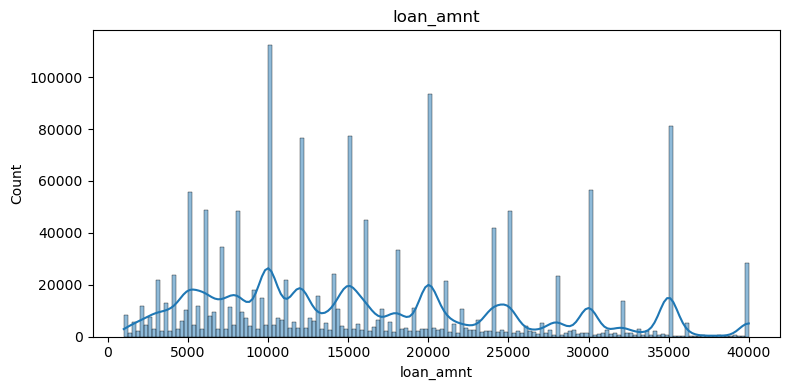

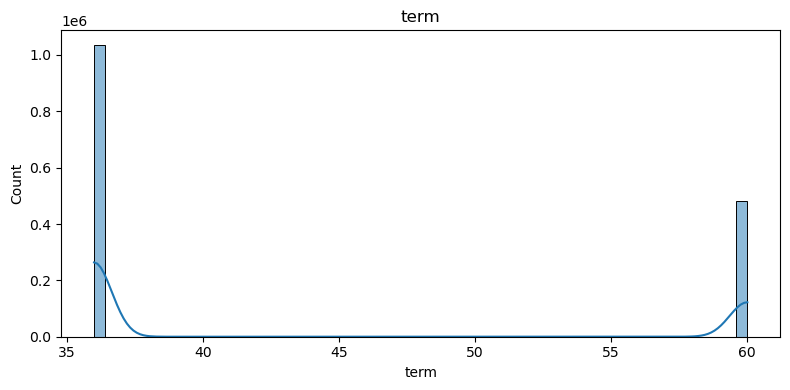

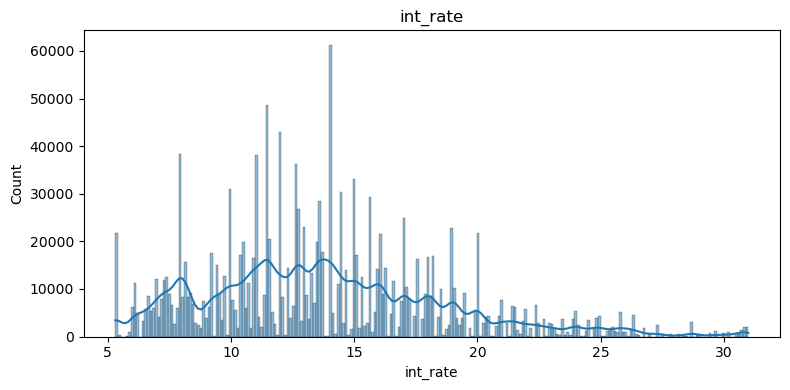

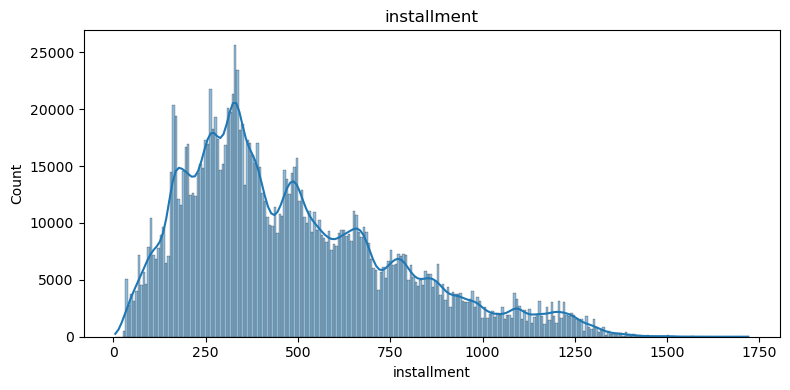

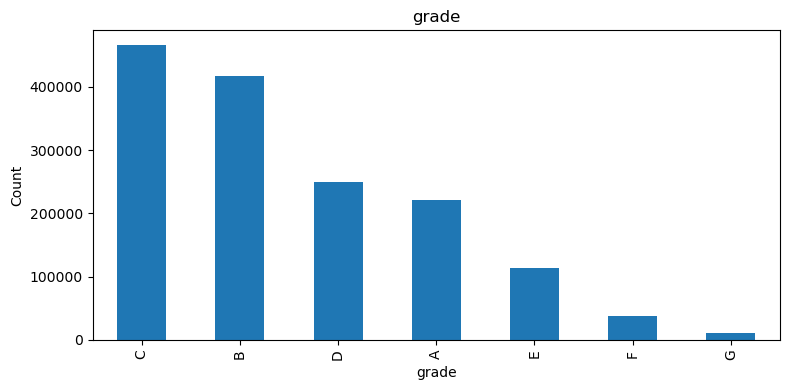

Skipping 'sub_grade' (too many categories: 35)
Skipping 'emp_title' (too many categories: 375924)


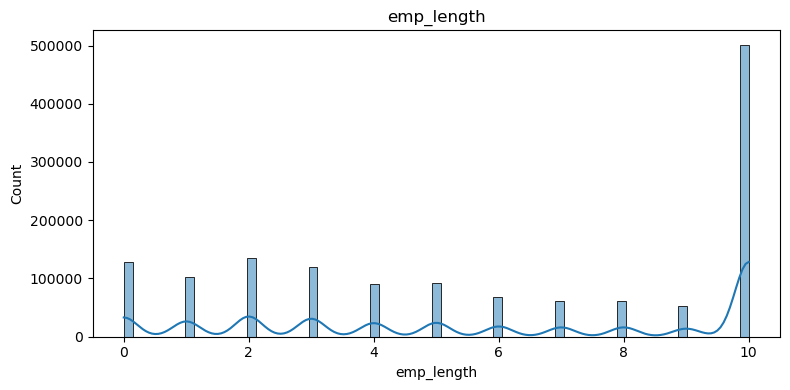

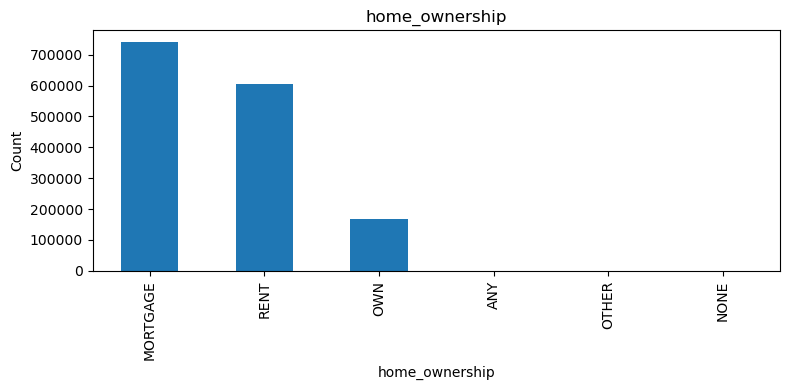

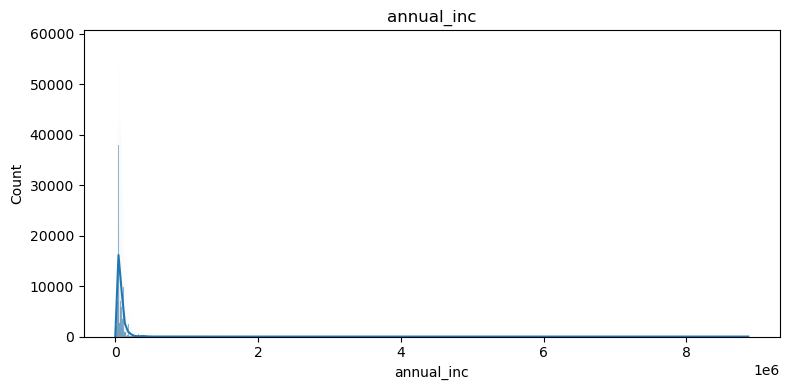

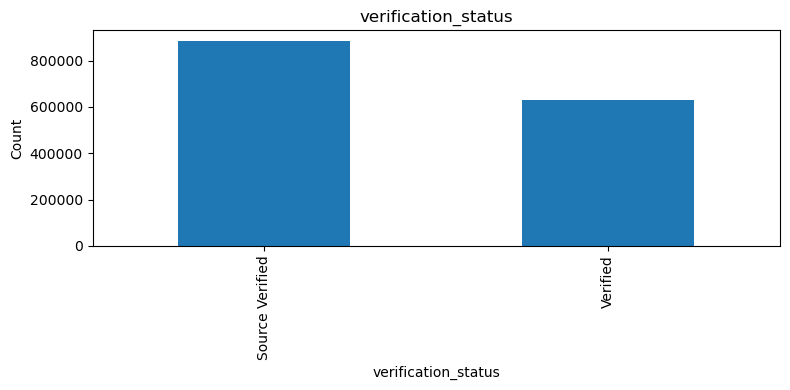

Skipping 'issue_d' (too many categories: 130)


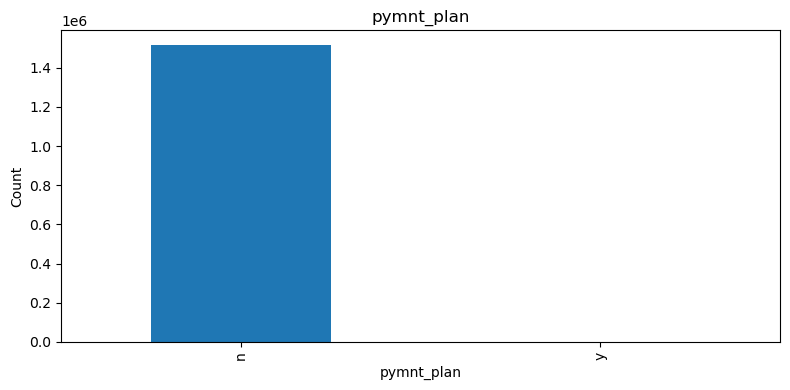

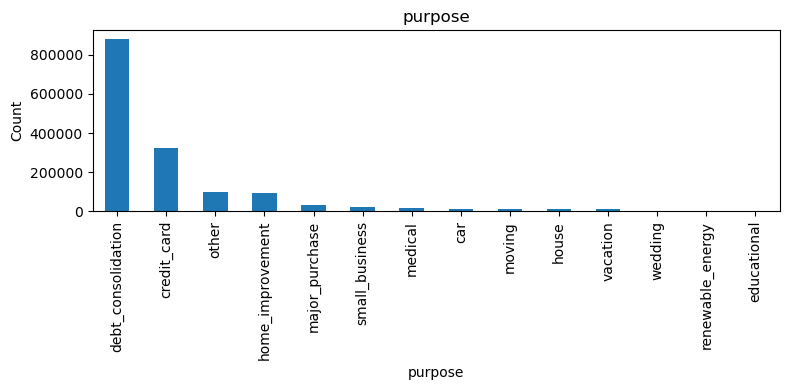

Skipping 'title' (too many categories: 41952)
Skipping 'zip_code' (too many categories: 947)
Skipping 'addr_state' (too many categories: 51)


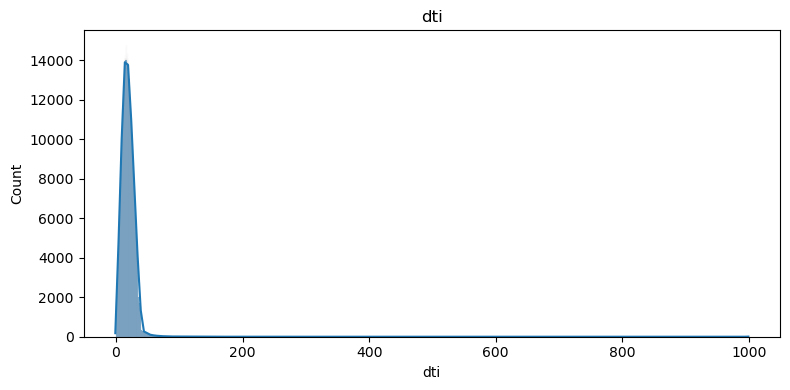

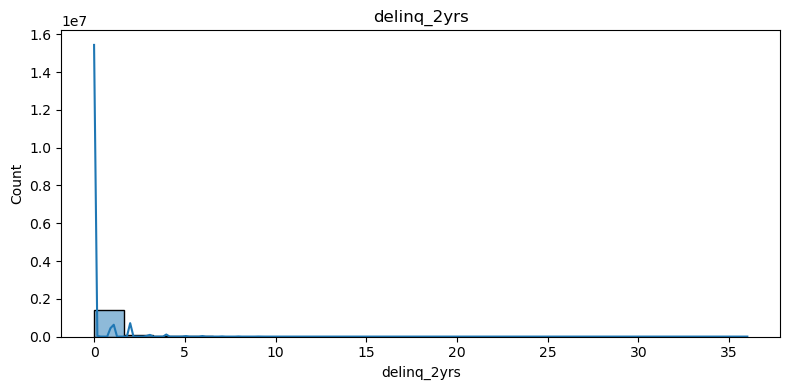

Skipping 'earliest_cr_line' (too many categories: 742)


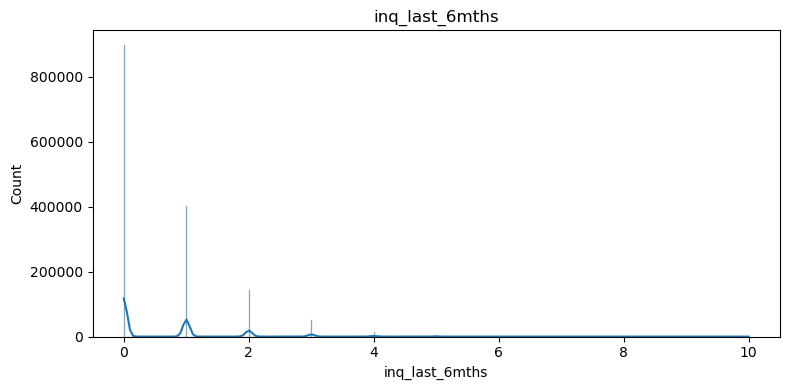

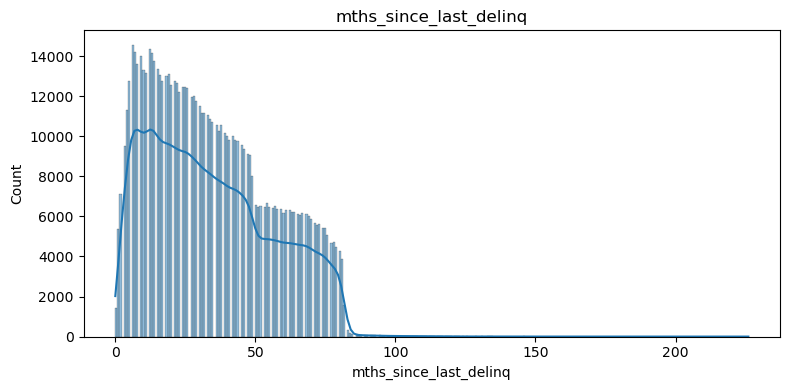

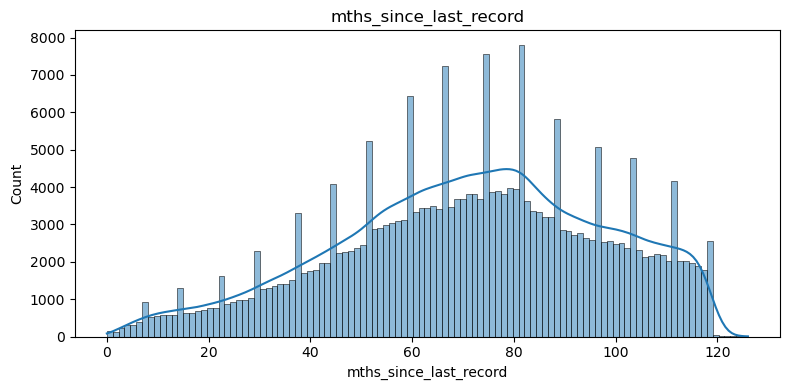

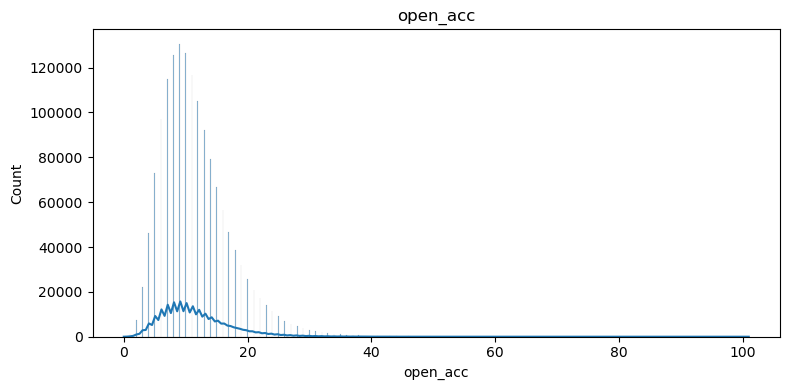

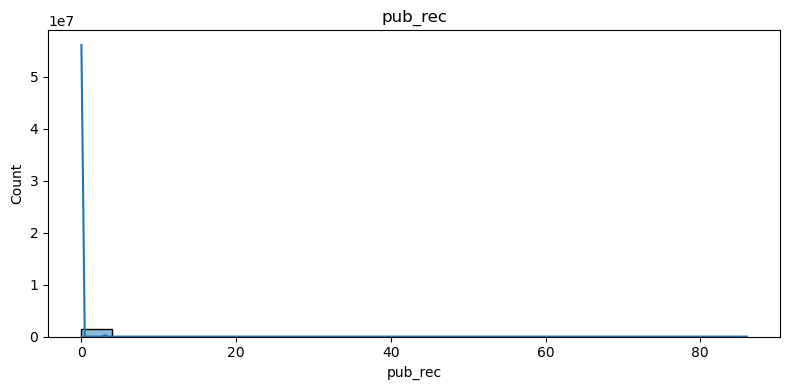

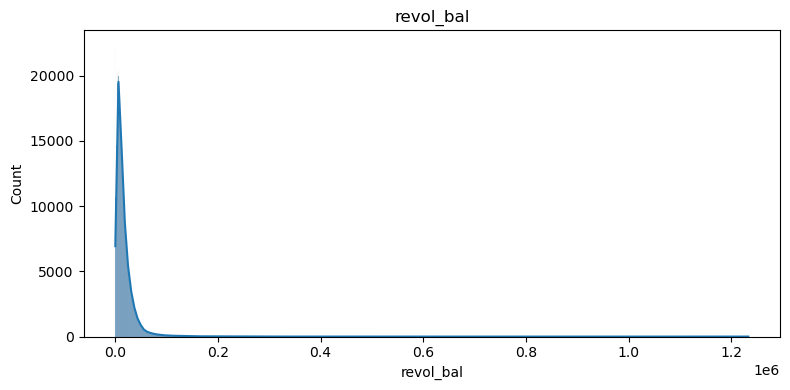

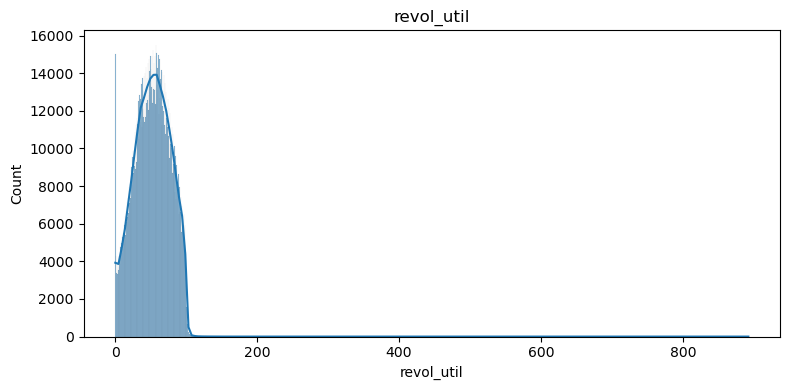

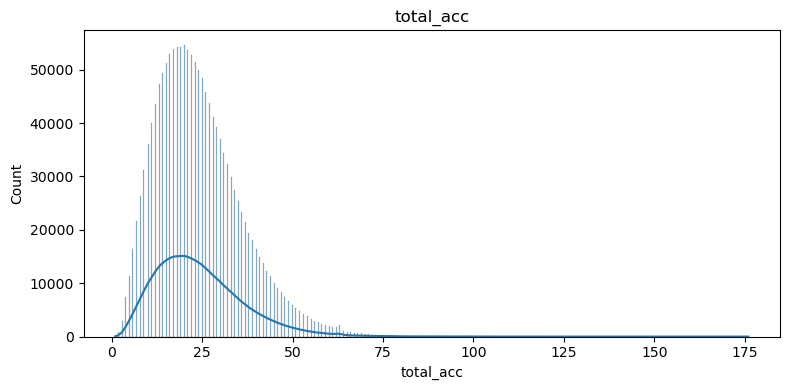

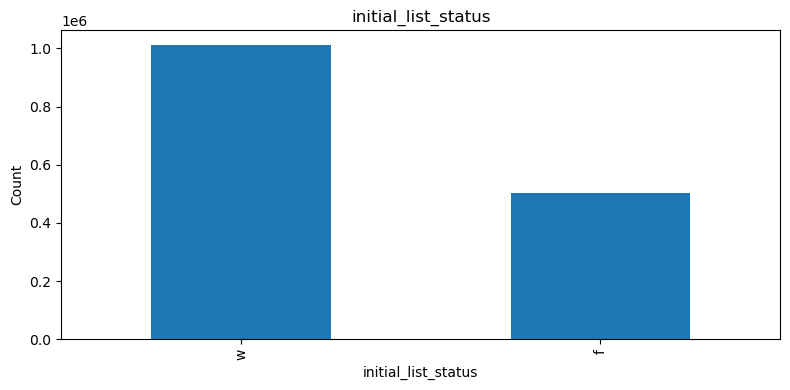

Skipping 'last_credit_pull_d' (too many categories: 124)


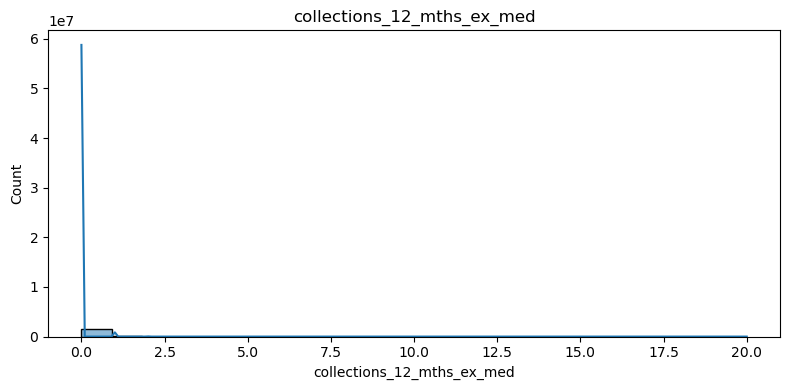

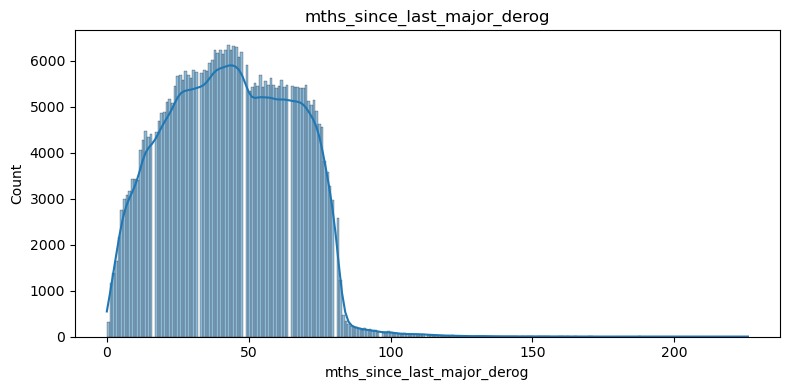

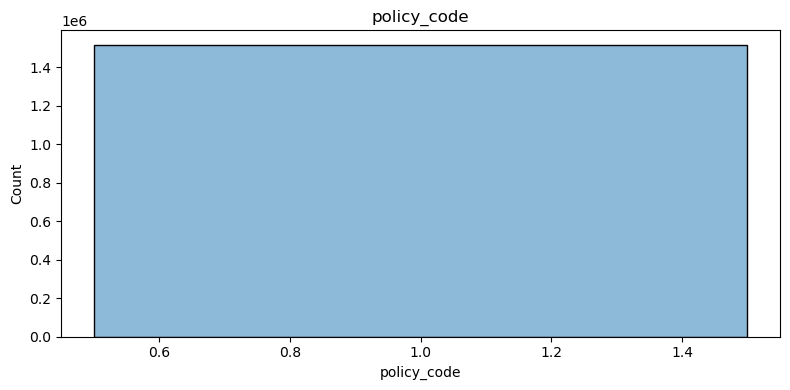

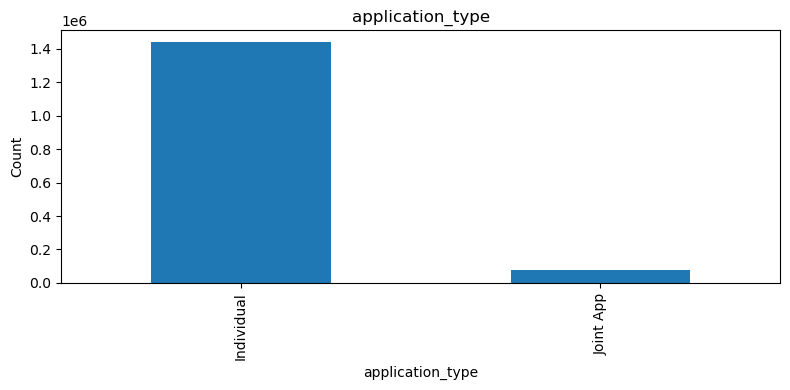

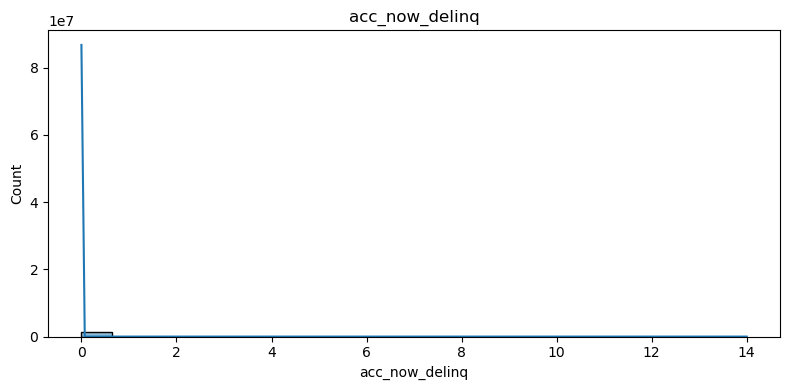

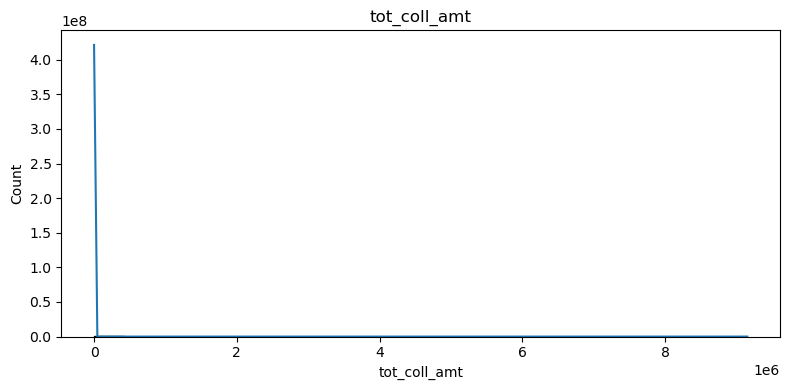

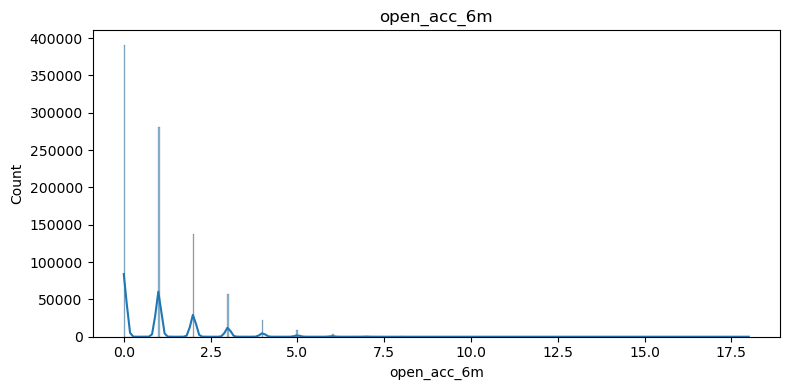

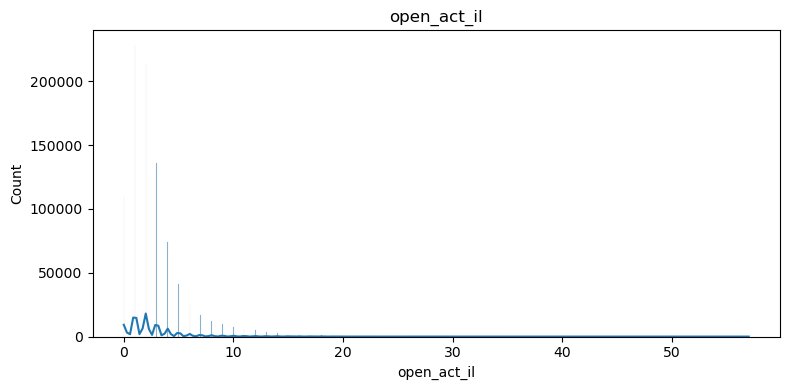

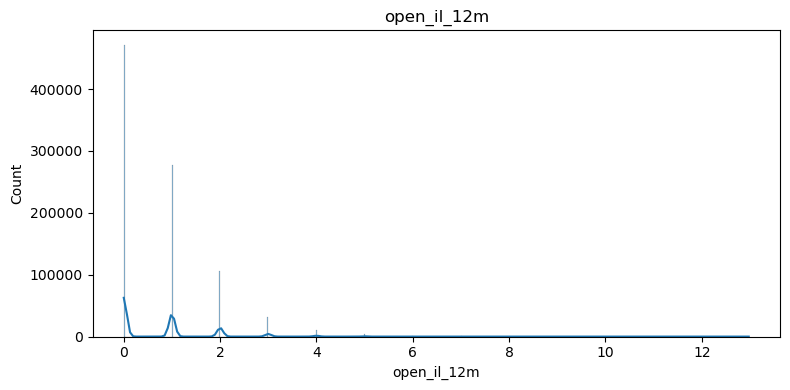

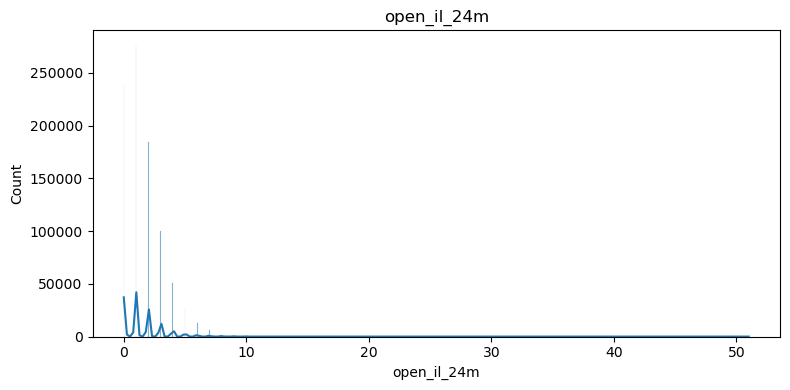

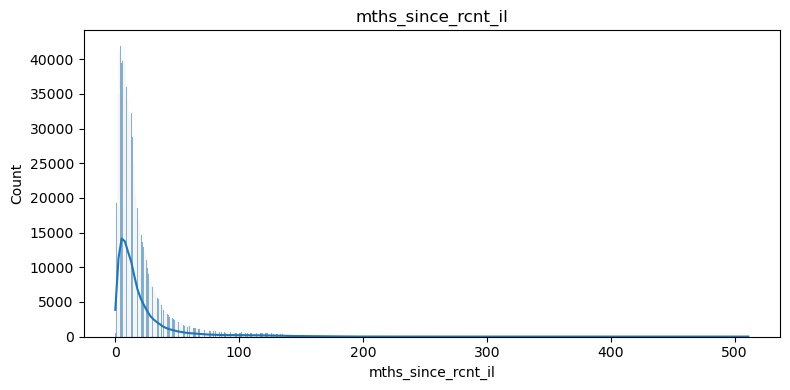

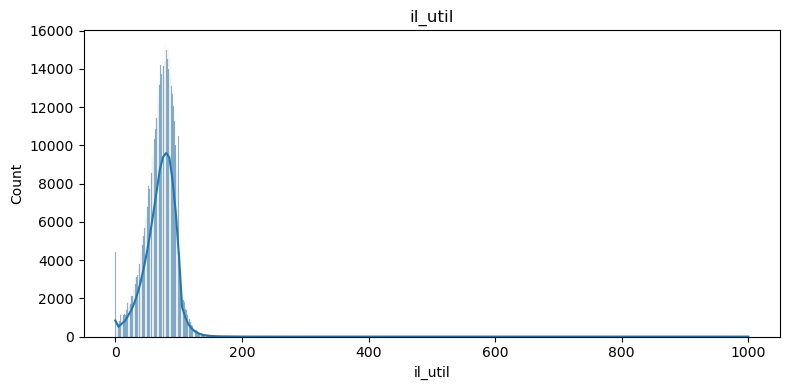

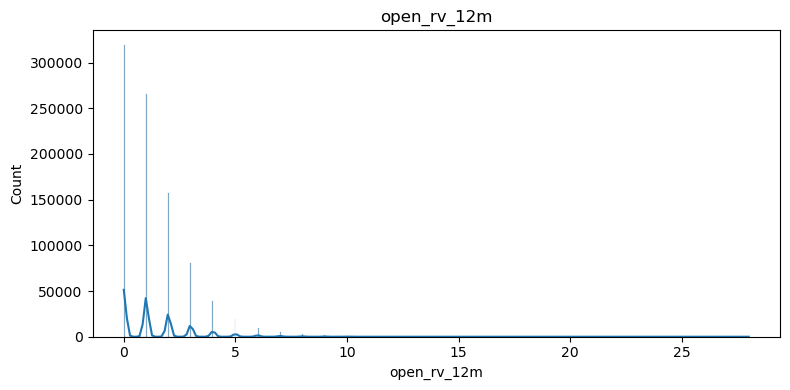

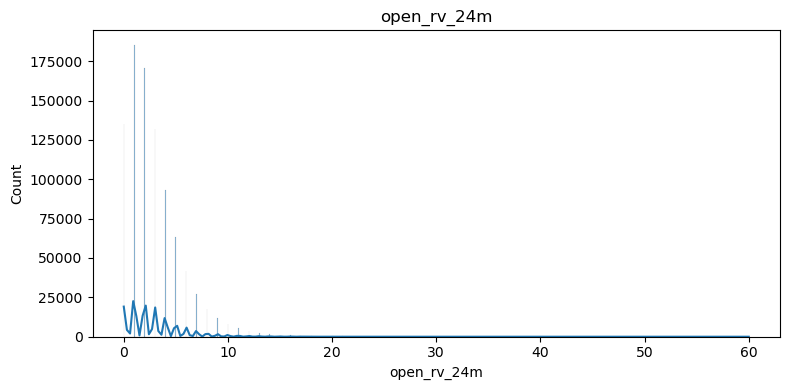

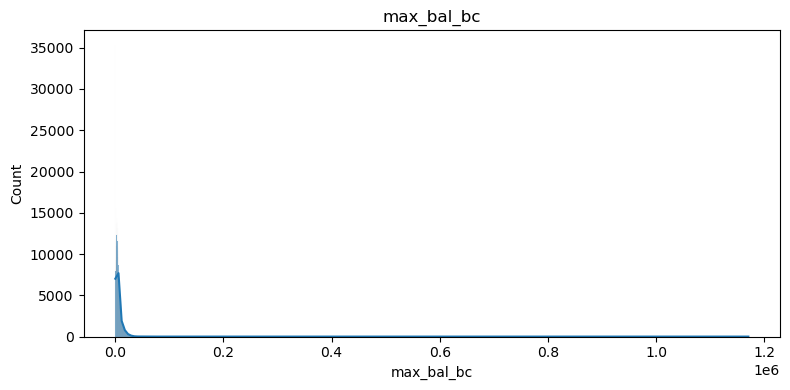

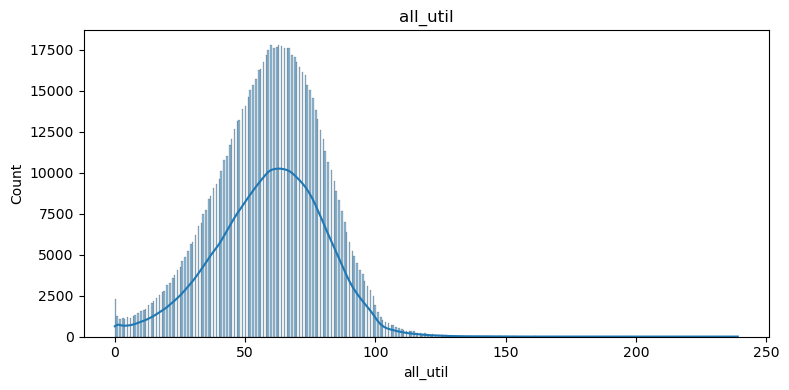

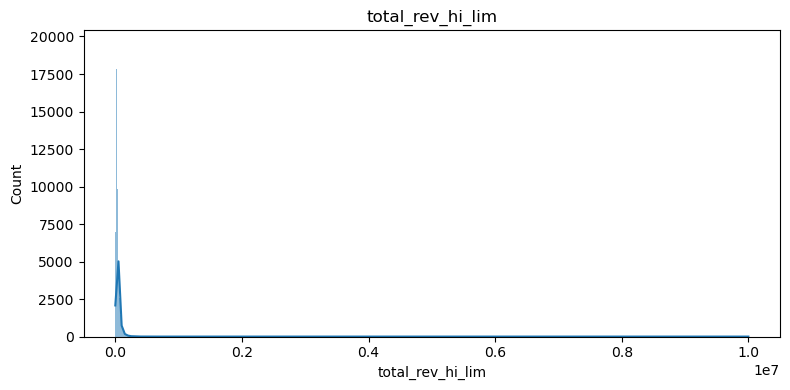

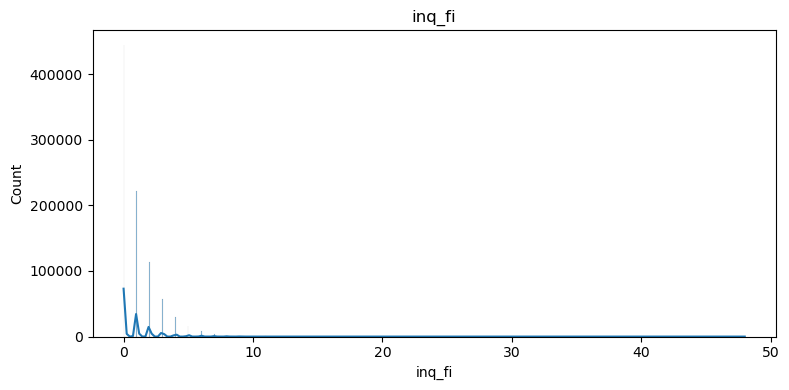

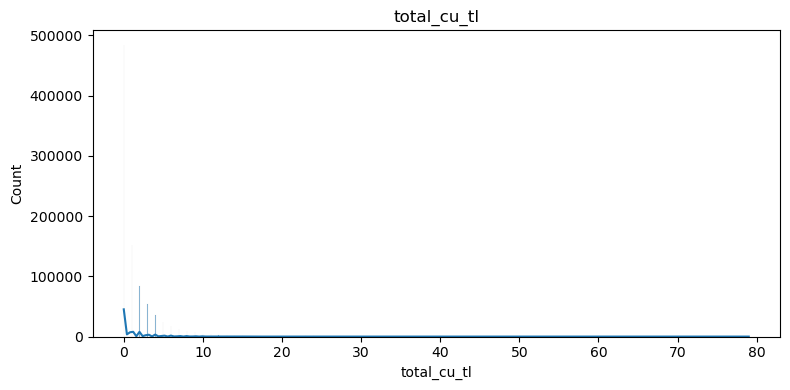

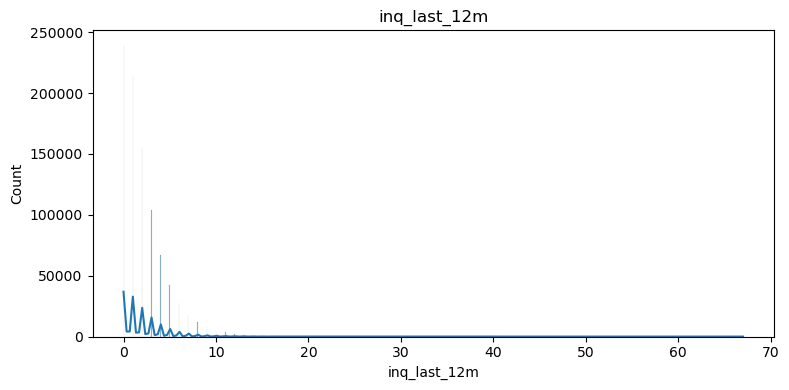

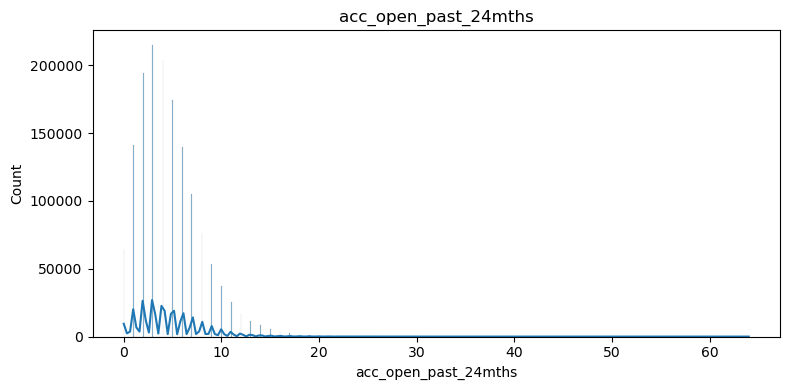

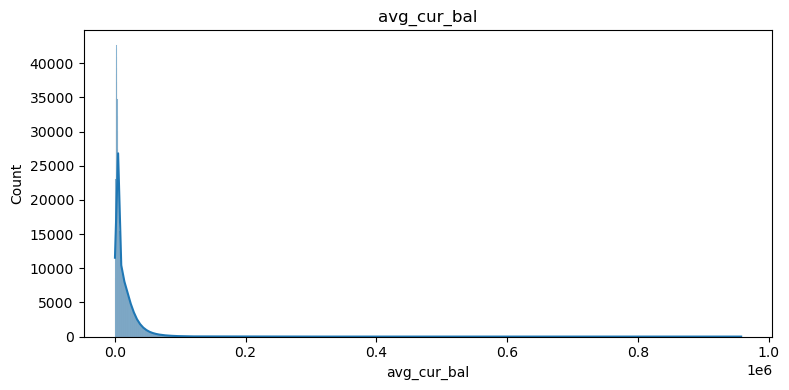

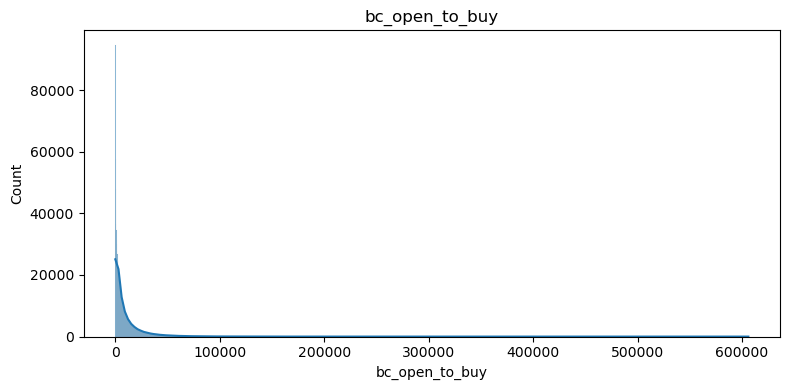

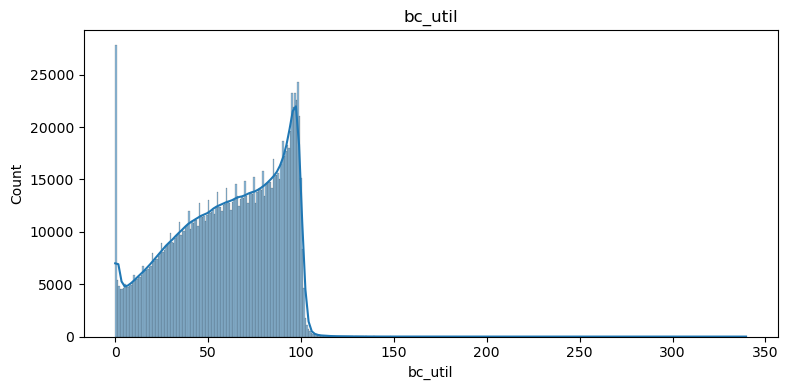

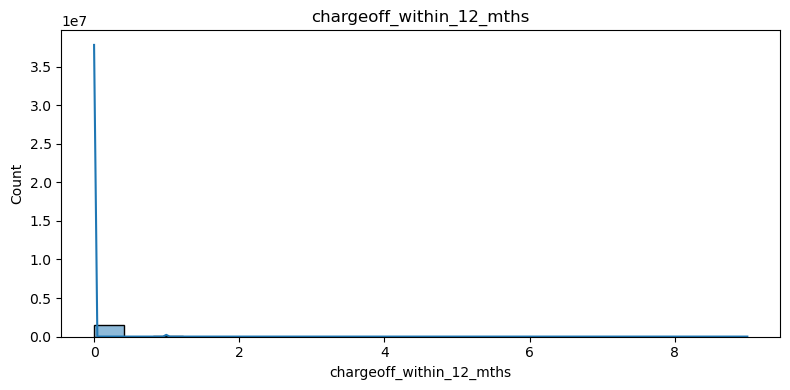

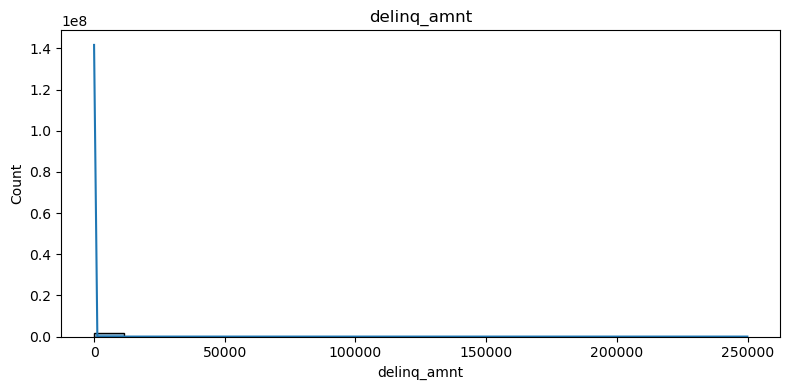

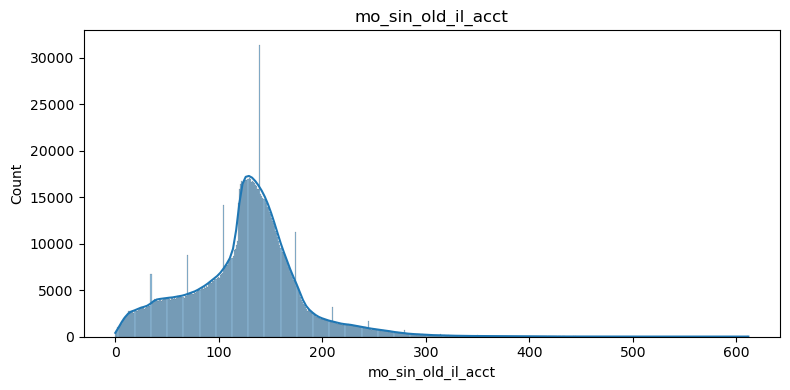

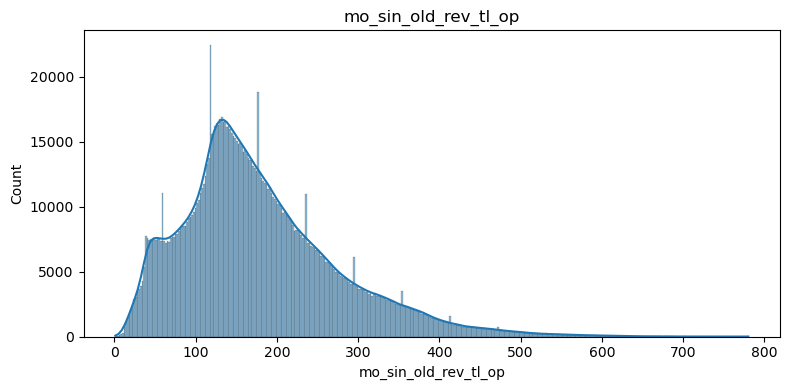

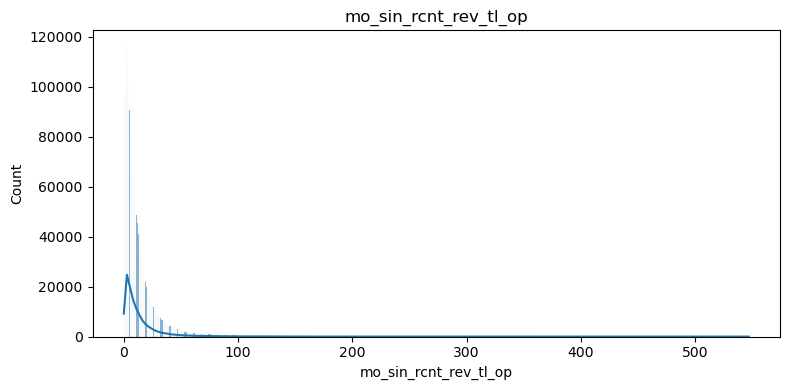

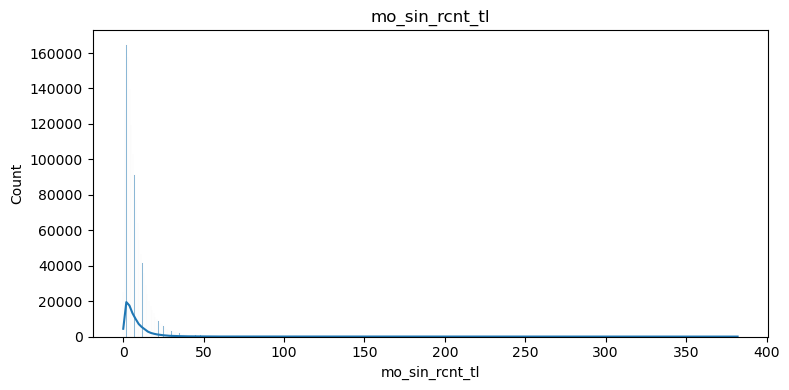

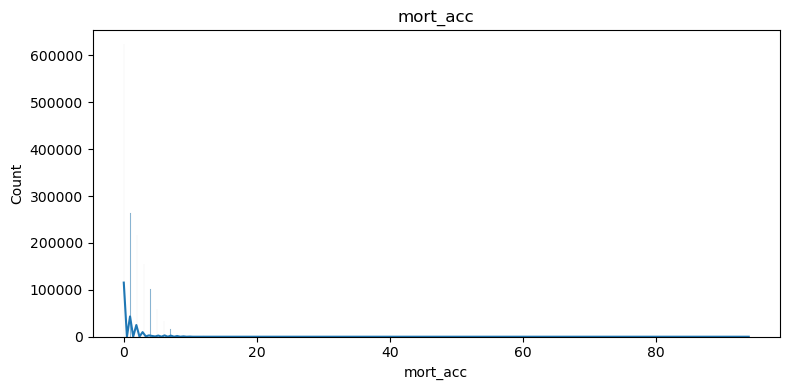

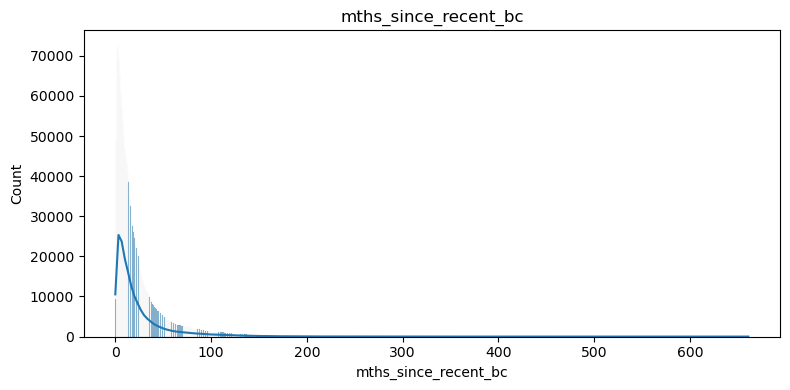

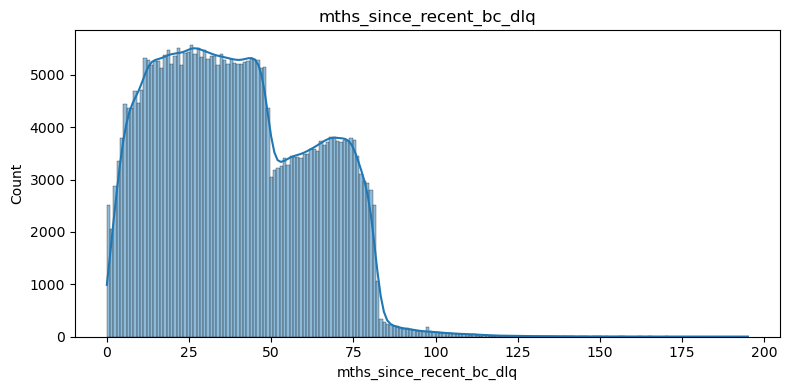

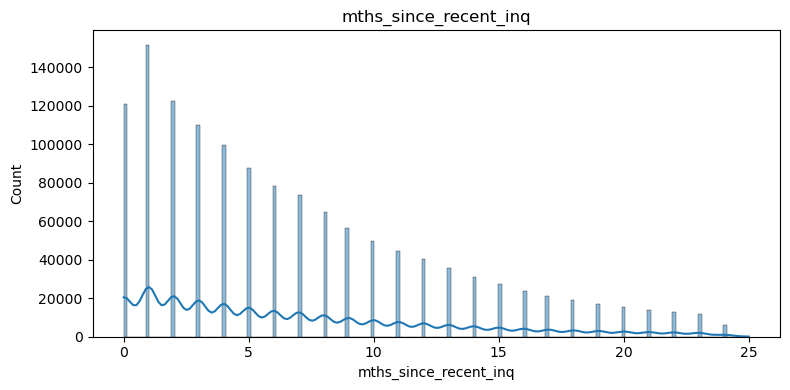

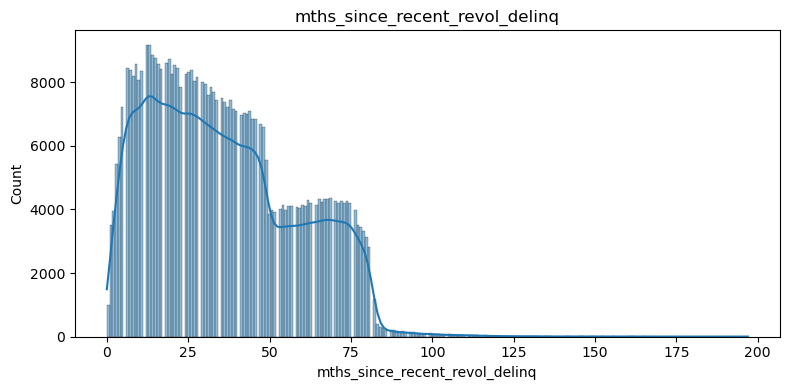

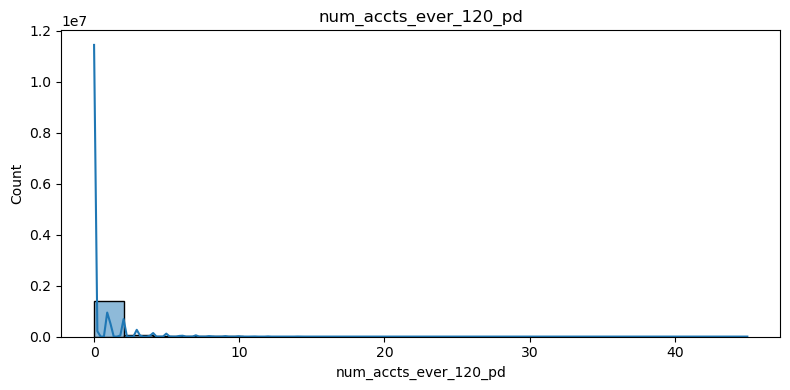

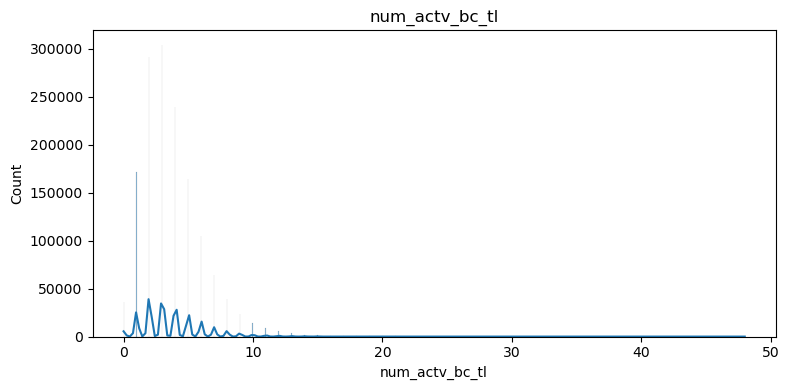

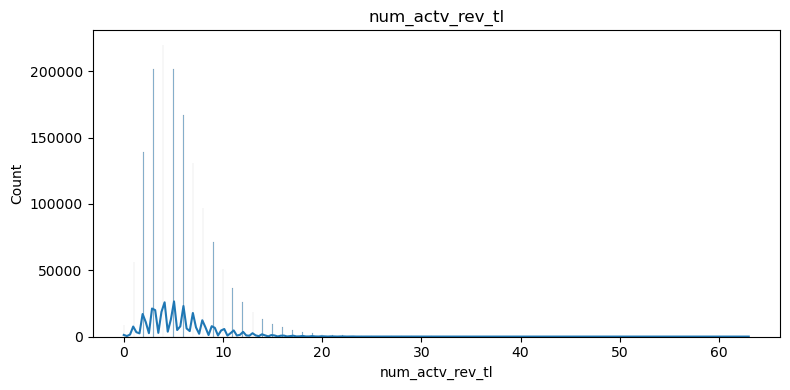

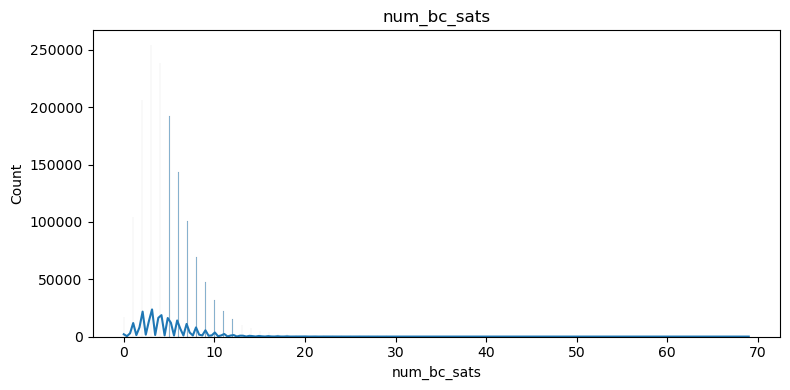

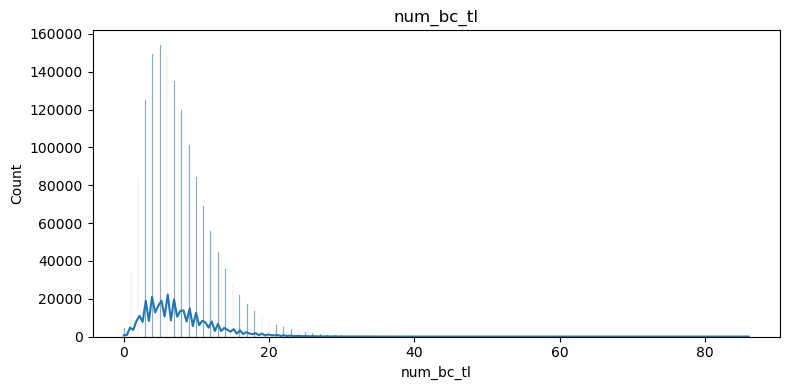

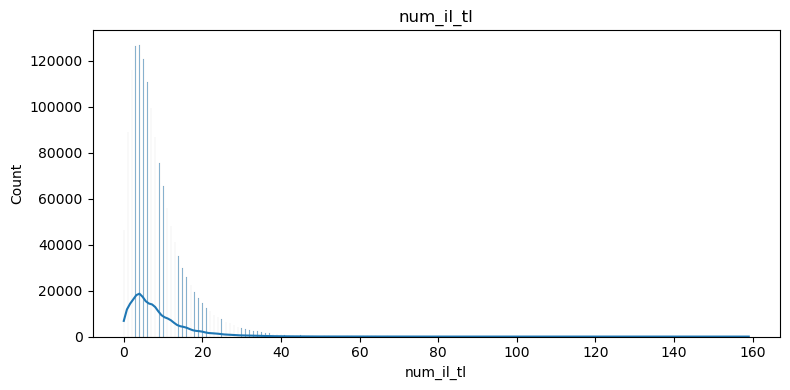

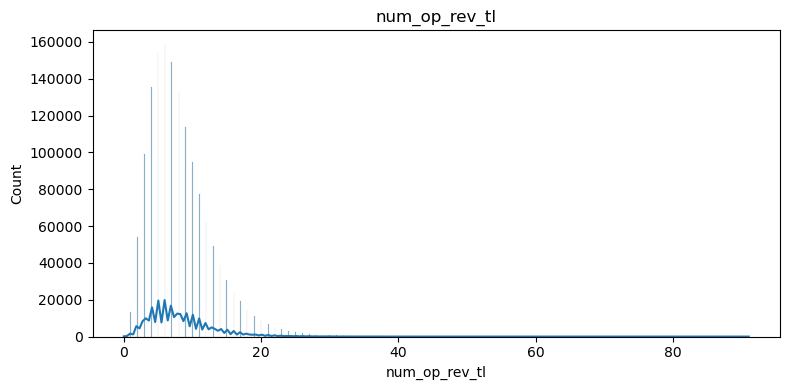

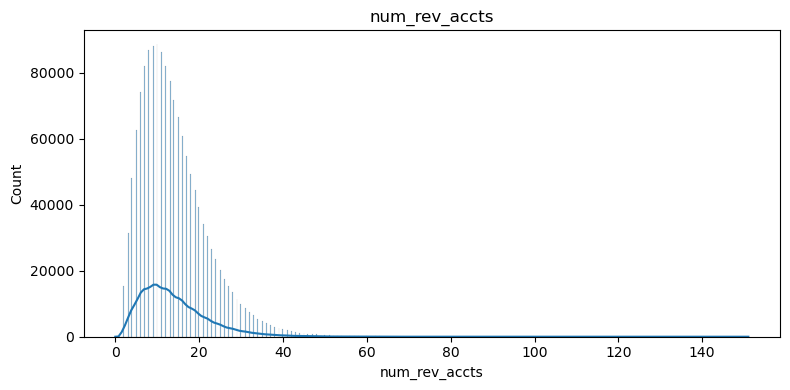

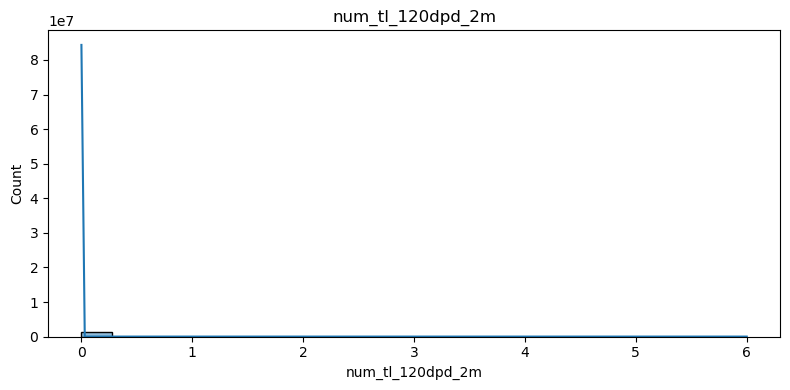

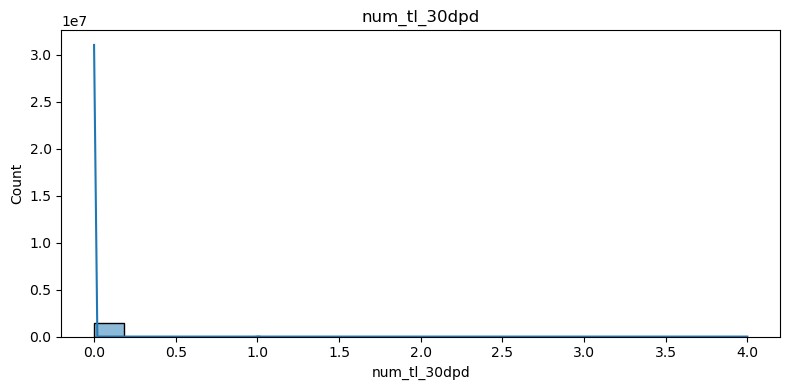

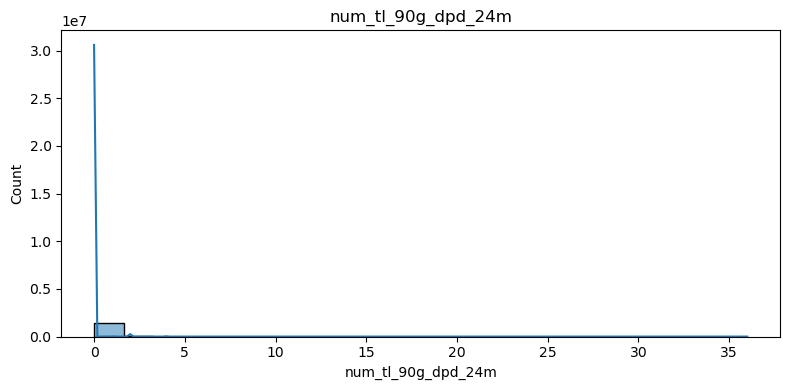

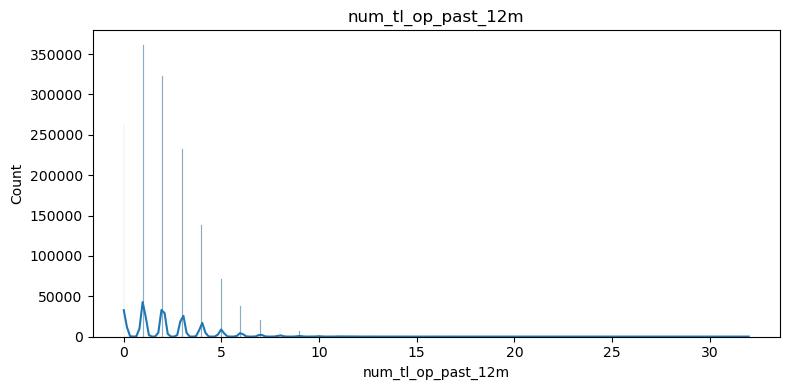

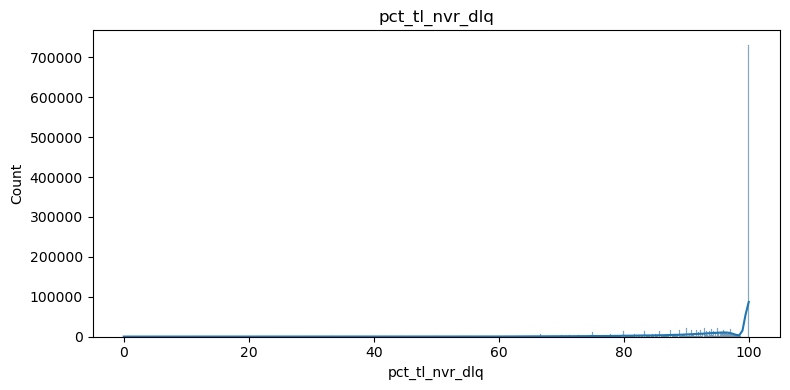

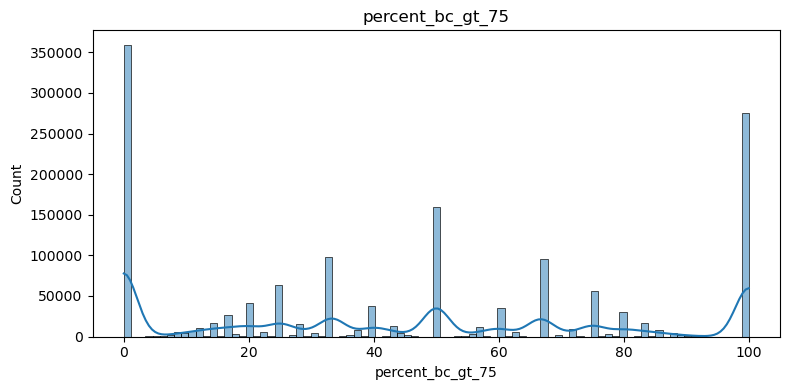

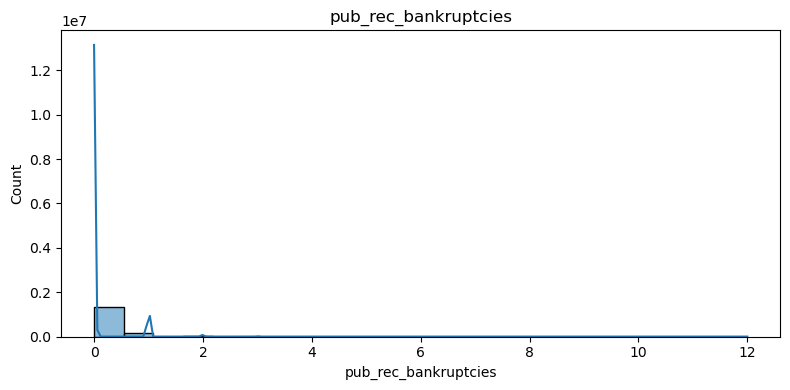

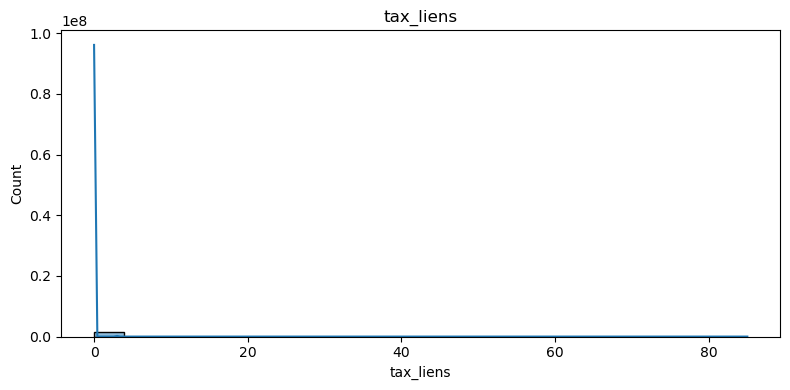

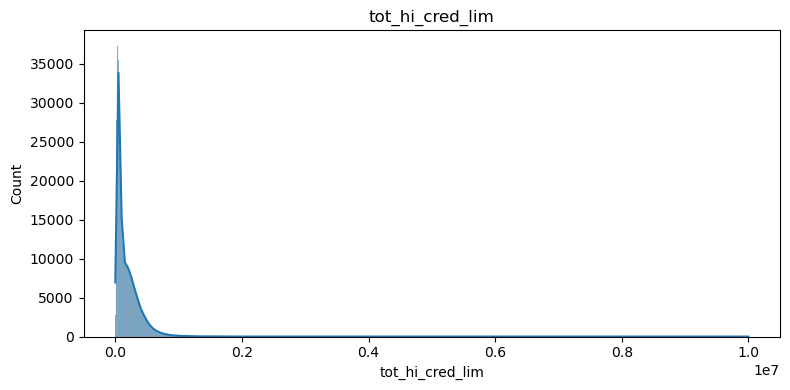

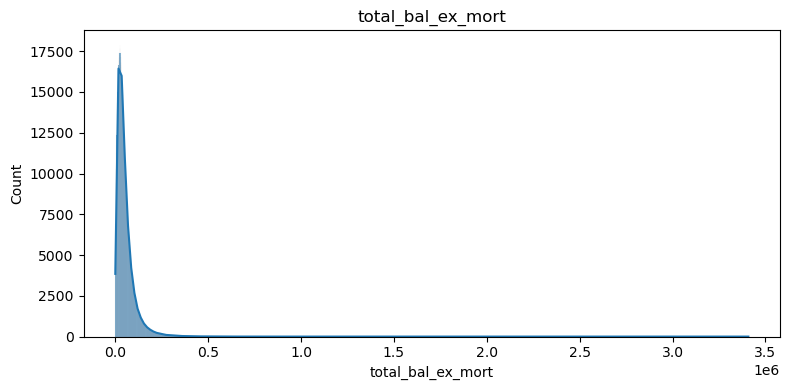

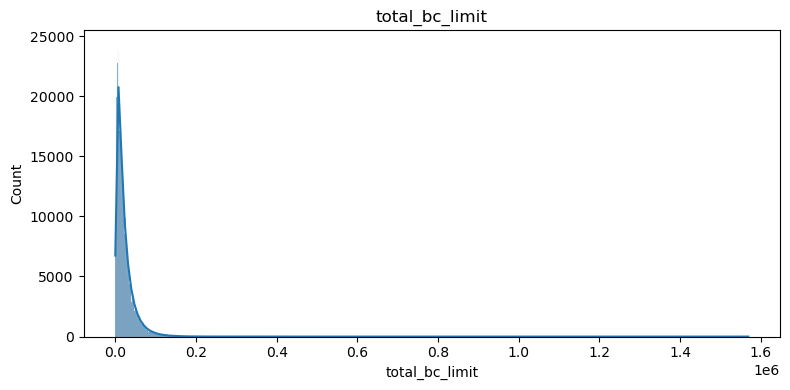

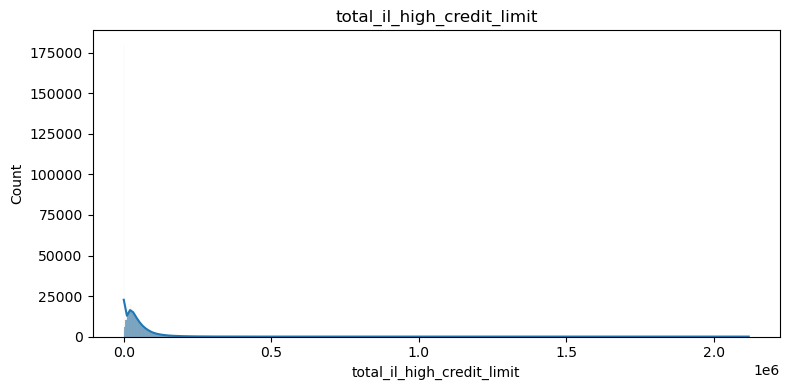

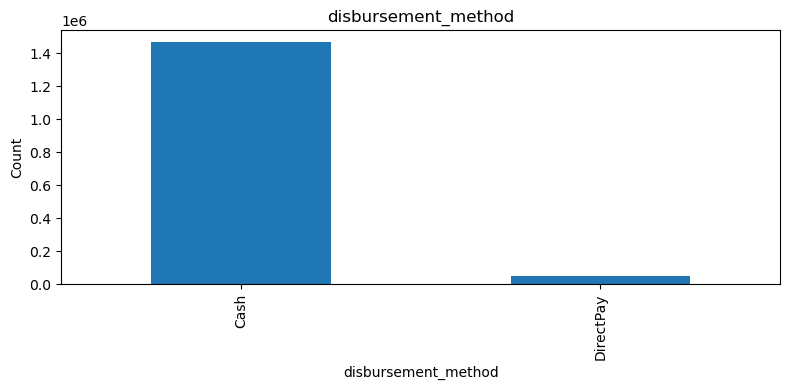

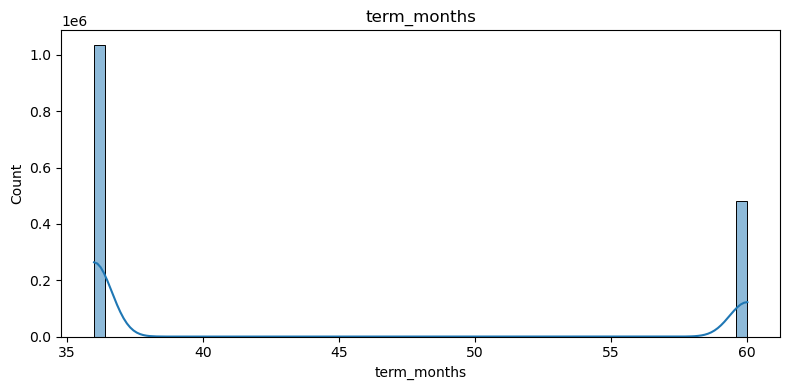

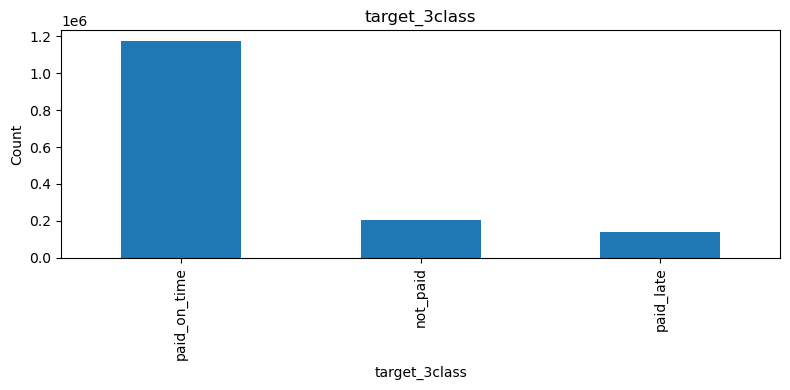

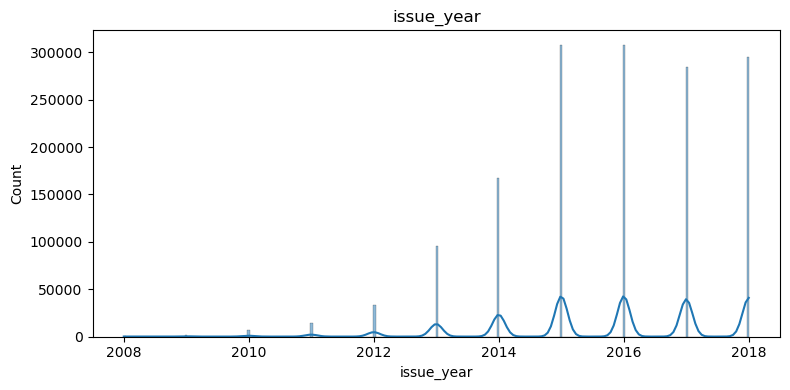

In [9]:
for col in df_minimal_clean.columns:
    plt.figure(figsize=(8, 4))
    plt.title(col)

    # Numeric columns
    if pd.api.types.is_numeric_dtype(df_minimal_clean[col]):
        sns.histplot(df_minimal_clean[col].dropna(), kde=True)
        plt.xlabel(col)

        # Categorical or text columns
    else:
        num_unique = df_minimal_clean[col].nunique()

        if num_unique <= 15:
            df_minimal_clean[col].value_counts().plot(kind="bar")
            plt.xlabel(col)
            plt.ylabel("Count")
        else:
            print(f"Skipping '{col}' (too many categories: {num_unique})")
            plt.close()
            continue

    plt.tight_layout()
    plt.show()

Based on the plots, and with Ori's advice, we capped values that were extremely large and not plausible:

In [ ]:
P99_CLIP_COLS = [
    "open_rv_12m",
    "open_rv_24m",
    "mort_acc",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "tax_liens",
    "num_tl_90g_dpd_24m",
]

In [18]:
def clip_p99(df, cols, q=0.99):
    """
    Clip values above the q-quantile (default P99) for selected columns.
    Safe: only clips columns that exist and are numeric.
    Returns a copy of df.
    """
    out = df.copy()
    applied = []

    for c in cols:
        if c not in out.columns:
            continue
        if not pd.api.types.is_numeric_dtype(out[c]):
            continue

        cap = out[c].quantile(q)
        out[c] = out[c].clip(upper=cap)
        applied.append((c, cap))

    print(f"Clipped {len(applied)} columns at P{int(q*100)}.")
    return out

df_minimal_clean = clip_p99(df_minimal_clean, P99_CLIP_COLS, q=0.99)

Clipped 27 columns at P99.


### parameter tuning

--- random forest ---

In [32]:
def make_balanced_sample(df, N, target_col="target_3class", random_state=42):
    k = df[target_col].nunique()
    per_class = N // k

    parts = []
    for cls, g in df.groupby(target_col):
        n_take = min(per_class, len(g))
        parts.append(g.sample(n_take, random_state=random_state))

    balanced = pd.concat(parts, ignore_index=True)

    remaining = N - len(balanced)
    if remaining > 0:
        balanced = pd.concat([balanced, df.sample(remaining, random_state=random_state)], ignore_index=True)

    return balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

df_tune_20k = make_balanced_sample(df_minimal_clean, 20000)
print(df_tune_20k["target_3class"].value_counts())

target_3class
paid_on_time    6668
paid_late       6666
not_paid        6666
Name: count, dtype: int64


In [33]:
X_20k = df_tune_20k.drop(columns=["target_3class"])
y_20k = df_tune_20k["target_3class"]

X_train_20k, X_test_20k, y_train_20k, y_test_20k = train_test_split(
    X_20k, y_20k, test_size=0.2, stratify=y_20k, random_state=42
)

preprocess_20k = make_preprocess(X_train_20k)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [34]:
rf_baseline = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        n_jobs=-1
    ))
])

rf_baseline.fit(X_train_20k, y_train_20k)
pred = rf_baseline.predict(X_test_20k)

print("RF baseline test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

RF baseline test f1_macro: 0.6689939202894476


In [15]:
rf_pipe_struct = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1))
])

rf_param_grid = {
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": [1, 2, 5, 10],
}

gs_struct = GridSearchCV(
    estimator=rf_pipe_struct,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs_struct.fit(X_train_20k, y_train_20k)

print("RF STRUCT best CV f1_macro:", gs_struct.best_score_)
print("RF STRUCT best params:", gs_struct.best_params_)

pred = gs_struct.best_estimator_.predict(X_test_20k)
print("RF STRUCT tuned test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.0s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.0s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.0s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.1s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.5s
[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   4.0s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.0s
[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   4.5s
[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   4.5s
[CV] END .........clf__max_depth=10, clf__min_samples_leaf=1; total time=   4.6s
[CV] END .........clf__max_depth=10, clf__min_samples_leaf=1; total time=   4.6s
[CV] END .........clf__max_depth=10, clf__min_sa

In [35]:
df_tune_120k = make_balanced_sample(df_minimal_clean, 120000)

X_120k = df_tune_120k.drop(columns=["target_3class"])
y_120k = df_tune_120k["target_3class"]

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

preprocess_120k = make_preprocess(X_train_120k)

In [17]:
rf_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=1
    ))
])

param_grid = {
    "clf__n_estimators": [200, 400, 700, 1000],
}

gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs.fit(X_train_120k, y_train_120k)

print("RF best CV f1_macro:", gs.best_score_)
print("RF best params:", gs.best_params_)

best_rf = gs.best_estimator_
pred = best_rf.predict(X_test_120k)
print("RF tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............................clf__n_estimators=200; total time=12.6min
[CV] END ..............................clf__n_estimators=200; total time=12.7min
[CV] END ..............................clf__n_estimators=200; total time=12.7min
[CV] END ..............................clf__n_estimators=400; total time=23.8min
[CV] END ..............................clf__n_estimators=400; total time=23.8min
[CV] END ..............................clf__n_estimators=400; total time=23.8min
[CV] END ..............................clf__n_estimators=700; total time=38.3min
[CV] END ..............................clf__n_estimators=700; total time=38.3min
[CV] END ..............................clf__n_estimators=700; total time=33.6min
[CV] END .............................clf__n_estimators=1000; total time=42.6min
[CV] END .............................clf__n_estimators=1000; total time=42.7min
[CV] END .............................clf__n_esti

checking random forest without one-hot incoding

In [73]:
# =========================================================
# 1) RF WITH OHE (your regular preprocess)
# =========================================================
preprocess_with_ohe = make_preprocess(X_train_120k)

rf_with_ohe = Pipeline([
    ("preprocess", preprocess_with_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400, 
        n_jobs=-1
    ))
])

rf_with_ohe.fit(X_train_120k, y_train_120k)
pred_with_ohe = rf_with_ohe.predict(X_test_120k)

with_ohe_acc = accuracy_score(y_test_120k, pred_with_ohe)
with_ohe_f1  = f1_score(y_test_120k, pred_with_ohe, average="macro")

print("=== RF WITH OHE ===")
print("Accuracy:", with_ohe_acc)
print("Macro F1:", with_ohe_f1)
print(classification_report(y_test_120k, pred_with_ohe))


# =========================================================
# 2) RF NO OHE (numeric only, same numeric treatment)
# =========================================================
numeric_cols = X_train_120k.select_dtypes(include="number").columns.tolist()
time_cols = [c for c in numeric_cols if c.startswith("mths_since_")]
num_regular = list(set(numeric_cols) - set(time_cols))

time_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
    ("scaler", StandardScaler())
])

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

preprocess_no_ohe = ColumnTransformer(
    transformers=[
        ("time", time_pipeline, time_cols),
        ("num", numeric_pipeline, num_regular),
        # intentionally no categorical transformer
    ],
    remainder="drop"
)

rf_no_ohe = Pipeline([
    ("preprocess", preprocess_no_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

rf_no_ohe.fit(X_train_120k, y_train_120k)
pred_no_ohe = rf_no_ohe.predict(X_test_120k)

no_ohe_acc = accuracy_score(y_test_120k, pred_no_ohe)
no_ohe_f1  = f1_score(y_test_120k, pred_no_ohe, average="macro")

print("\n=== RF NO OHE (numeric only) ===")
print("Accuracy:", no_ohe_acc)
print("Macro F1:", no_ohe_f1)
print(classification_report(y_test_120k, pred_no_ohe))


# =========================================================
# 3) Quick comparison (one line)
# =========================================================
print("\n=== COMPARISON ===")
print(f"WITH OHE -> Acc: {with_ohe_acc:.4f}, MacroF1: {with_ohe_f1:.4f}")
print(f"NO OHE   -> Acc: {no_ohe_acc:.4f}, MacroF1: {no_ohe_f1:.4f}")
print(f"Delta MacroF1 (NO - WITH): {(no_ohe_f1 - with_ohe_f1):+.4f}")


=== RF WITH OHE ===
Accuracy: 0.682
Macro F1: 0.6742036081153698
              precision    recall  f1-score   support

           0       0.71      0.52      0.60      8000
           1       0.67      0.88      0.76      8000
           2       0.67      0.64      0.66      8000

    accuracy                           0.68     24000
   macro avg       0.69      0.68      0.67     24000
weighted avg       0.69      0.68      0.67     24000


=== RF NO OHE (numeric only) ===
Accuracy: 0.6499583333333333
Macro F1: 0.6407632258431856
              precision    recall  f1-score   support

           0       0.62      0.49      0.54      8000
           1       0.65      0.87      0.74      8000
           2       0.68      0.59      0.63      8000

    accuracy                           0.65     24000
   macro avg       0.65      0.65      0.64     24000
weighted avg       0.65      0.65      0.64     24000


=== COMPARISON ===
WITH OHE -> Acc: 0.6820, MacroF1: 0.6742
NO OHE   -> Acc: 0.6

--- logistic regression ---

In [36]:
lr_pipe_tuning = Pipeline([
    ("pre", preprocess_120k),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

lr_pipe_tuning.fit(X_train_120k, y_train_120k)
y_pred = lr_pipe_tuning.predict(X_test_120k)
baseline_lr_f1 = f1_score(y_test_120k, y_pred, average="macro")

print("Baseline LR Macro F1:", baseline_lr_f1)

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline LR Macro F1: 0.7130044040689664


In [22]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logreg_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        penalty="l2",
        max_iter=2000,
        n_jobs=-1
    ))
])

logreg_param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0],
    "clf__class_weight": [None, "balanced"]
}

logreg_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

logreg_search.fit(X_train_120k, y_train_120k)

print("LogReg best CV F1:", logreg_search.best_score_)
print("LogReg best params:", logreg_search.best_params_)

pred = logreg_search.best_estimator_.predict(X_test_120k)
print("LogReg tuned test F1:", f1_score(y_test_120k, pred, average="macro"))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=  53.1s
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time=  53.6s
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time=  54.5s
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=  56.1s
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time=  56.3s
[CV] END ................clf__C=0.01, clf__class_weight=None; total time=  56.5s
[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 2.0min
[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 2.3min
[CV] END ............clf__C=0.05, clf__class_weight=balanced; total time= 1.9min
[CV] END ............clf__C=0.05, clf__class_weight=balanced; total time= 2.0min
[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 2.1min
[CV] END ............clf__C=0.05, clf__class_wei

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................clf__C=1.0, clf__class_weight=None; total time= 5.3min
[CV] END .............clf__C=1.0, clf__class_weight=balanced; total time= 4.2min
[CV] END .............clf__C=1.0, clf__class_weight=balanced; total time= 4.5min
LogReg best CV F1: 0.7182598981828257
LogReg best params: {'clf__C': 0.05, 'clf__class_weight': None}
LogReg tuned test F1: 0.7193635517841289


--- xgboost ---

In [37]:
y_cat = df_tune_120k["target_3class"].astype("category")
label_map = dict(enumerate(y_cat.cat.categories))
print("label_map:", label_map)

y_120k = y_cat.cat.codes

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)


label_map: {0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


In [38]:
xgb_baseline = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,

        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

xgb_baseline.fit(X_train_120k, y_train_120k)
pred = xgb_baseline.predict(X_test_120k)
print("XGB baseline test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

XGB baseline test f1_macro: 0.735577654044748


In [37]:
xgb_param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7, 10],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.2, 0.6],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train_120k, y_train_120k)

print("XGB best CV f1_macro:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_
pred = best_xgb.predict(X_test_120k)
print("XGB tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 1.6min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 1.6min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 1.5min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 1.6min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 1.5min
[CV] END clf__colsample_bytree=0.8, clf

In [38]:
xgb_param_refined = {
    "clf__n_estimators": [400, 500, 650, 800],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__max_depth": [8, 10, 12],
    "clf__min_child_weight": [3, 5, 7],
    "clf__gamma": [0.2, 0.6, 1.0],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.5, 0.6, 0.7],
}


xgb_search_refined = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_refined,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search_refined.fit(X_train_120k, y_train_120k)

print("XGB refined best CV f1_macro:", xgb_search_refined.best_score_)
print("XGB refined best params:", xgb_search_refined.best_params_)

best_xgb_refined = xgb_search_refined.best_estimator_
pred = best_xgb_refined.predict(X_test_120k)
print("XGB refined tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 6.9min
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 6.9min
[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 7.4min
[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 7.5min
[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 7.6min
[CV] END clf__colsample_

In [21]:
final_xgb_params = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": 8,
    "min_child_weight": 5,
    "gamma": 0.2,
    "subsample": 0.9,
    "colsample_bytree": 0.5,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}

Calibration curve


In [61]:
# Fitting XGBoost with the tuned hyperparameters
X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"]

# Convert target for XGBoost
y = y.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# Build preprocessing based only on the feature matrix
preprocess = make_preprocess(X_train)


# Parameters according to the tuning
model = XGBClassifier(**final_xgb_params )


pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# Fit
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [62]:
y_cat = df_minimal_clean["target_3class"].astype("category")
code_to_label = dict(enumerate(y_cat.cat.categories))

y = y_cat.cat.codes
print(code_to_label)

{0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


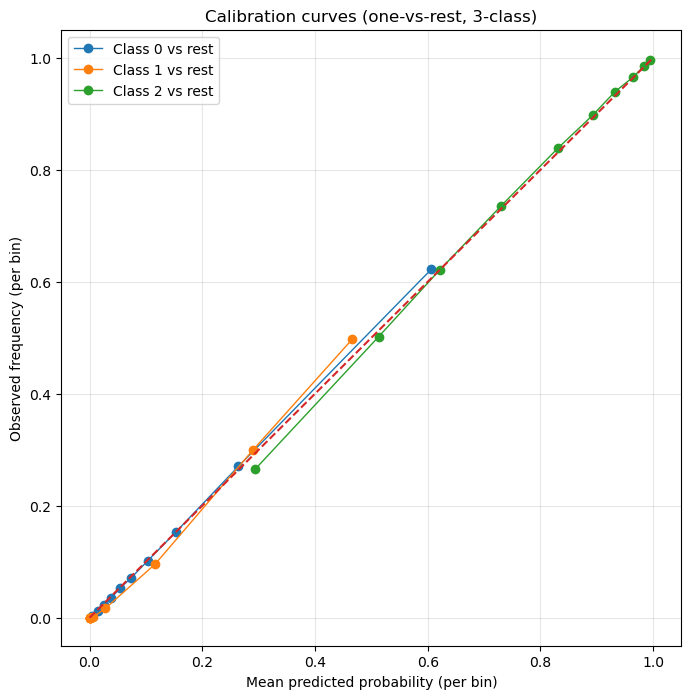

In [42]:
def plot_multiclass_calibration_curves(fitted_pipe, X, y, n_bins=10, strategy="quantile"):
    """
    Multiclass calibration via one-vs-rest curves.
    For each class k: compare predicted P(Y=k) vs observed frequency of Y=k.
    """
    proba = fitted_pipe.predict_proba(X)
    # shape: (n_samples, 3)
    # proba[i,j] = the model’s predicted probability that sample i belongs to class j.


    plt.figure(figsize=(8, 8))

    for k in range(3):  # because the labels are 0/1/2
        y_bin = (y == k).astype(int)  # 1 if class k, else 0

        frac_pos, mean_pred = calibration_curve(
            y_bin,
            proba[:, k],
            n_bins=n_bins,
            strategy=strategy
        )

        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=f"Class {k} vs rest")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability (per bin)")
    plt.ylabel("Observed frequency (per bin)")
    plt.title("Calibration curves (one-vs-rest, 3-class)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_multiclass_calibration_curves(pipe, X_test, y_test)

### Threshold Tuning ###

In [ ]:
y_pred_base = pipe.predict(X_test)

print("BASE Macro F1:", f1_score(y_test, y_pred_base, average="macro"))
print(classification_report(y_test, y_pred_base, target_names=code_to_label.values()))

BASE Macro F1: 0.58124142970824
              precision    recall  f1-score   support

    not_paid       0.71      0.36      0.48     40796
   paid_late       0.59      0.27      0.37     27578
paid_on_time       0.83      0.96      0.89    234799

    accuracy                           0.82    303173
   macro avg       0.71      0.53      0.58    303173
weighted avg       0.80      0.82      0.79    303173



In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
model = XGBClassifier(**final_xgb_params)
model.fit(X_tr, y_tr)

# Make sure class order is consistent (important for thresholds dict)
classes = list(model.classes_)
print("Class order:", classes)
proba_val = model.predict_proba(X_val)

In [ ]:
def predict_with_thresholds(proba, thresholds):
    """
    proba: array (n_samples, n_classes)
    thresholds: dict {class_index: threshold}

    Strategy:
    - if a class probability exceeds its threshold -> candidate
    - if multiple candidates -> take highest probability among them
    - if none -> fallback to argmax
    """
    preds = []
    for p in proba:
        candidates = [k for k, t in thresholds.items() if p[k] >= t]

        if len(candidates) == 1:
            preds.append(candidates[0])
        elif len(candidates) > 1:
            preds.append(max(candidates, key=lambda k: p[k]))
        else:
            preds.append(int(np.argmax(p)))

    return np.array(preds)

In [ ]:
grid_not_paid    = np.arange(0.20, 0.31, 0.03)
grid_paid_late   = np.arange(0.20, 0.31, 0.02)
grid_paid_ontime = np.arange(0.55, 0.66, 0.04)

In [ ]:
best_score = -1
best_thresholds = None

for t0, t1, t2 in product(grid_not_paid, grid_paid_late, grid_paid_ontime):
    thresholds = {0: t0, 1: t1, 2: t2}
    preds_val = predict_with_thresholds(proba_val, thresholds)
    score = f1_score(y_val, preds_val, average="macro")

    if score > best_score:
        best_score = score
        best_thresholds = thresholds

print("\nBEST VAL Macro F1:", best_score)
print("BEST VAL thresholds:", best_thresholds)


# Optional: see VAL report at best thresholds
pred_val_best = predict_with_thresholds(proba_val, best_thresholds)
print("\n===== VAL @ BEST THRESHOLDS =====")
print("VAL Accuracy:", accuracy_score(y_val, pred_val_best))
print("VAL Macro F1:", f1_score(y_val, pred_val_best, average="macro"))
print(confusion_matrix(y_val, pred_val_best, labels=classes))
print(classification_report(y_val, pred_val_best, digits=4))

In [ ]:
final_model = XGBClassifier(**final_xgb_params)
final_model.fit(X_train, y_train)

# baseline (argmax)
pred_test_base = final_model.predict(X_test)

# thresholds
proba_test = final_model.predict_proba(X_test)
pred_test_thr = predict_with_thresholds(proba_test, best_thresholds)

print("\n===== TEST RESULTS =====")
print("BASE  Macro F1:", f1_score(y_test, pred_test_base, average="macro"))
print("THR   Macro F1:", f1_score(y_test, pred_test_thr, average="macro"))

print("\n--- BASE (argmax) report ---")
print(classification_report(y_test, pred_test_base, digits=4))

print("\n--- THRESHOLDS report ---")
print(classification_report(y_test, pred_test_thr, digits=4))

### Feature Importance ###

In [76]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

preprocess = make_preprocess(X_train_120k)

xgb_final = XGBClassifier(**final_xgb_params)

xgb_pipe_final = Pipeline([
    ("preprocess", preprocess),
    ("clf", xgb_final)
])

xgb_pipe_final.fit(X_train_120k, y_train_120k)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mths_since_last_delinq',
                                                   'mths_since_last_record',
                                                   'mths_since_last_major_derog',
                                                   'mths_since_rcnt_il',
                                                   'mths_since_recent_bc',
                                                   'mths_since_recent_bc_dlq',
                                                   'mt...
                               feature_types=None, feature_weights=None,
                               gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=800, n_jobs=-1,
                               num_class=3, ...))])

In [ ]:
def top_k_xgb_feature_importance_pipeline(
    fitted_pipeline,
    top_k=5,
    importance_type="gain",
    preprocess_step="preprocess",
    model_step="clf"
):
    pre = fitted_pipeline.named_steps[preprocess_step]
    model = fitted_pipeline.named_steps[model_step]

    feature_names = pre.get_feature_names_out()
    feature_names = np.array(feature_names)

    booster = model.get_booster()
    score_dict = booster.get_score(importance_type=importance_type)

    rows = []
    for k, v in score_dict.items():
        if k.startswith("f"):
            idx = int(k[1:])
            if idx < len(feature_names):
                rows.append((feature_names[idx], v))

    fi = pd.DataFrame(rows, columns=["feature", f"importance_{importance_type}"])
    fi = fi.sort_values(by=f"importance_{importance_type}", ascending=False).reset_index(drop=True)

    return fi.head(top_k), fi



In [ ]:
top5, full_fi = top_k_xgb_feature_importance_pipeline(
    xgb_pipe_final,
    top_k=5,
    importance_type="gain"
)

print(top5)

                             feature  importance_gain
0  num__missingindicator_open_il_24m       183.231613
1  num__missingindicator_open_rv_24m       176.511749
2   cat__last_credit_pull_d_Oct-2016       174.757263
3  num__missingindicator_open_il_12m       151.211533
4     num__missingindicator_all_util       136.478424


In [ ]:
importance_col = [c for c in full_fi.columns if c.startswith("importance_")][0]

full_fi["importance_pct"] = (
    full_fi[importance_col] / full_fi[importance_col].sum() * 100
)

top5_pct = full_fi.head(5)[["feature", "importance_pct"]]

print("TOP 5 RAW FEATURES (%):")
print(top5_pct)


TOP 5 RAW FEATURES (%):
                             feature  importance_pct
0  num__missingindicator_open_il_24m        3.444052
1  num__missingindicator_open_rv_24m        3.317744
2   cat__last_credit_pull_d_Oct-2016        3.284766
3  num__missingindicator_open_il_12m        2.842197
4     num__missingindicator_all_util        2.565271


In [ ]:
def aggregate_ohe_base_features(fi_df, importance_col):
    tmp = fi_df.copy()

    def base_feature_name(f):
        f = f.replace("preprocess__", "")

        if f.startswith("cat__") and "_" in f:
            base = f.rsplit("_", 1)[0]
            return base

        return f

    tmp["base_feature"] = tmp["feature"].apply(base_feature_name)

    agg = (
        tmp.groupby("base_feature", as_index=False)[importance_col]
        .sum()
        .sort_values(by=importance_col, ascending=False)
        .reset_index(drop=True)
    )

    return agg

importance_col = [c for c in full_fi.columns if c.startswith("importance_")][0]

agg_top5 = aggregate_ohe_base_features(full_fi, importance_col).head(5)

agg_top5


,base_feature,importance_gain
0,cat__zip_code,1051.096970
1,cat__earliest_cr_line,858.638333
2,cat__last_credit_pull_d,832.159325
3,cat__emp_title,460.932445
4,num__missingindicator_open_il_24m,183.231613


In [ ]:
agg_fi = aggregate_ohe_base_features(full_fi, importance_col)

agg_fi["importance_pct"] = (
    agg_fi[importance_col] / agg_fi[importance_col].sum() * 100
)

agg_top5_pct = agg_fi.head(5)[["base_feature", "importance_pct"]]

print("TOP 5 BASE FEATURES (%):")
print(agg_top5_pct)


TOP 5 BASE FEATURES (%):
                        base_feature  importance_pct
0                      cat__zip_code       19.756592
1              cat__earliest_cr_line       16.139107
2            cat__last_credit_pull_d       15.641404
3                     cat__emp_title        8.663762
4  num__missingindicator_open_il_24m        3.444052


###Top 5 features model###

In [47]:
TOP5_BASE_FEATURES = [
    "zip_code",
    "earliest_cr_line",
    "last_credit_pull_d",
    "emp_title",
    "open_il_24m"
]

In [48]:
def make_preprocess_top5(df):
    cat_cols = ["zip_code", "earliest_cr_line", "last_credit_pull_d", "emp_title"]
    num_cols = ["open_il_24m"]

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ])

In [ ]:
X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"].astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

preprocess_top5 = make_preprocess_top5(X_train)

xgb_top5 = Pipeline([
    ("preprocess", preprocess_top5),
    ("clf", XGBClassifier(**final_xgb_params))
])

xgb_top5.fit(X_train, y_train)

y_pred_top5 = xgb_top5.predict(X_test)

acc_top5 = accuracy_score(y_test, y_pred_top5)
f1_top5  = f1_score(y_test, y_pred_top5, average="macro")

print("XGB TOP 5 FEATURES")
print("Accuracy:", acc_top5)
print("Macro F1:", f1_top5)
print(classification_report(y_test, y_pred_top5))

XGB TOP 5 FEATURES
Accuracy: 0.7959152035306574
Macro F1: 0.4195728905166807
              precision    recall  f1-score   support

           0       0.73      0.23      0.35     40796
           1       0.47      0.01      0.03     27578
           2       0.80      0.99      0.88    234799

    accuracy                           0.80    303173
   macro avg       0.67      0.41      0.42    303173
weighted avg       0.76      0.80      0.73    303173



In [ ]:
#comparison between full model and top 5 features model
top5_acc = acc_top5
top5_f1  = f1_top5
print("\n=== MODEL COMPARISON ===")

print(f"FULL MODEL (XGB + thresholds)")
print(f"Accuracy : {full_acc:.4f}")
print(f"Macro F1 : {full_f1:.4f}")

print("\nTOP 5 FEATURES ONLY")
print(f"Accuracy : {top5_acc:.4f}")
print(f"Macro F1 : {top5_f1:.4f}")

print("\nΔ (Top5 - Full)")
print(f"Δ Accuracy : {top5_acc - full_acc:+.4f}")
print(f"Δ Macro F1 : {top5_f1 - full_f1:+.4f}")



=== MODEL COMPARISON ===
FULL MODEL (XGB + thresholds)
Accuracy : 0.7968
Macro F1 : 0.6536

TOP 5 FEATURES ONLY
Accuracy : 0.7959
Macro F1 : 0.4196

Δ (Top5 − Full)
Δ Accuracy : -0.0008
Δ Macro F1 : -0.2340


CI

In [80]:
##ci bootstrap CI for final model
def bootstrap_ci_final_model(y_test, y_pred_final, n_boot=2000, random_state=42):
    """
    95% bootstrap confidence intervals for Accuracy and Macro-F1
    on the FINAL model predictions (fixed model, resample TEST set).
    """

    # Convert to numpy arrays (fixes pandas indexing issues)
    y_test = np.asarray(y_test)
    y_pred_final = np.asarray(y_pred_final)

    rng = np.random.default_rng(random_state)
    n = len(y_test)

    acc_scores = np.empty(n_boot)
    f1_scores  = np.empty(n_boot)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)  # sample positions with replacement

        y_true_sample = y_test[idx]
        y_pred_sample = y_pred_final[idx]

        acc_scores[b] = accuracy_score(y_true_sample, y_pred_sample)
        f1_scores[b]  = f1_score(y_true_sample, y_pred_sample, average="macro")

    # 95% CI = [2.5%, 97.5%]
    acc_low, acc_high = np.percentile(acc_scores, [2.5, 97.5])
    f1_low,  f1_high  = np.percentile(f1_scores,  [2.5, 97.5])

    return {
        "accuracy_mean": float(acc_scores.mean()),
        "accuracy_ci_low": float(acc_low),
        "accuracy_ci_high": float(acc_high),
        "macro_f1_mean": float(f1_scores.mean()),
        "macro_f1_ci_low": float(f1_low),
        "macro_f1_ci_high": float(f1_high),
    }


# --- run CI on your FINAL model predictions ---
ci = bootstrap_ci_final_model(y_test, y_pred_final, n_boot=2000, random_state=42)

print("FINAL MODEL (XGB + thresholds) - 95% Confidence Intervals")
print(f"Accuracy : {ci['accuracy_mean']:.4f} [{ci['accuracy_ci_low']:.4f}, {ci['accuracy_ci_high']:.4f}]")
print(f"Macro F1 : {ci['macro_f1_mean']:.4f} [{ci['macro_f1_ci_low']:.4f}, {ci['macro_f1_ci_high']:.4f}]")


FINAL MODEL (XGB + thresholds) - 95% Confidence Intervals
Accuracy : 0.7968 [0.7954, 0.7982]
Macro F1 : 0.6536 [0.6514, 0.6560]


### Evaluation ###

In [ ]:
TARGET_COL = "target_3class"
BAD_CLASS_NAME = "not_paid"  # change if your worst class label is different

# -----------------------
# 1) Prepare DEV (train) and TEST (frozen) matrices
# -----------------------
X_dev = df_minimal_clean.drop(columns=[TARGET_COL]).copy()
y_dev_cat = df_minimal_clean[TARGET_COL].astype("category")
class_names = list(y_dev_cat.cat.categories)
y_dev = y_dev_cat.cat.codes.to_numpy()

X_test = df_test.drop(columns=[TARGET_COL]).copy()
y_test_cat = pd.Categorical(df_test[TARGET_COL], categories=class_names)
y_test = pd.Series(y_test_cat).cat.codes.to_numpy()

K = len(class_names)

# -----------------------
# 2) Fit final model once on ALL dev (no extra splits)
# -----------------------
preprocess = make_preprocess(X_dev)
model = XGBClassifier(**final_xgb_params)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

pipe.fit(X_dev, y_dev)

# -----------------------
# 3) Evaluate on test only
# -----------------------
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=list(range(K)))
y_test_oh = np.eye(K)[y_test]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
    "log_loss": log_loss(y_test, y_proba, labels=list(range(K))),
    "brier_multiclass": float(np.mean(np.sum((y_proba - y_test_oh) ** 2, axis=1))),
    "roc_auc_ovr_macro": roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro"),
    "pr_auc_macro": average_precision_score(y_test_bin, y_proba, average="macro"),
}

cm = confusion_matrix(y_test, y_pred, labels=list(range(K)))
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

print("\n============================================================")
print("EVALUATION — FROZEN TEST SET ONLY (10%)")
print("============================================================")
print(f"Classes (order): {class_names}")
print(f"Test size: {len(df_test):,}\n")

for k in [
    "accuracy", "balanced_accuracy",
    "f1_macro", "f1_weighted",
    "roc_auc_ovr_macro", "pr_auc_macro",
    "log_loss", "brier_multiclass"
]:
    print(f"{k:22s}: {metrics[k]:.6f}")

print("\nConfusion Matrix (counts):")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

print("\nConfusion Matrix (row-normalized):")
print(pd.DataFrame(cm_norm, index=class_names, columns=class_names).round(4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

# -----------------------
# 4) Plots: ROC, PR, Calibration (TEST)
# -----------------------
plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    frac_pos, mean_pred = calibration_curve(
        y_test_bin[:, i], y_proba[:, i],
        n_bins=10, strategy="quantile"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves (per class) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

### bad loaners features ###